# Results

This notebook includes all the results, and some notes about them

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

In [2]:
with open("all_results/arxpr3_scores.json") as f:
#with open("all_results/study_type_scores.json") as f:
    data = json.load(f)


Score data is all the scores (ones or zeros) that the averages are calculated from. These are also used for calculating p-values.

index data is the indices (of the literal, that is shufled for each paper) of the chosen answers, and the corroct answer, used to show that early indices are chosen more often.

choice data is the actual predicted and correct answers

In [3]:
score_data = data["scores"]
index_data = data["index_logs"]
choice_data = data["choice_log"]

In [4]:
print(len(score_data)) # how many runs do we have results from?

67


In [5]:
for i in score_data:
    l =len(score_data[i]["hardware_4"])
    #print(l)

if False:
    L = 150 # how many papers do we want to look at the reslts from
    remove_runs = []
    for i in score_data:
        l =len(score_data[i]["hardware_4"])
        if l != L:
            remove_runs.append(i)
    for i in remove_runs:
        score_data.pop(i)
        index_data.pop(i)
        choice_data.pop(i)

    len(score_data) # how many runs do we have results from, with L papers?

To evaluate total score (not only each field) we make an array with all scores

In [6]:
def add_total_score(score_dict):
    for key in score_dict:
        total = []
        for field in score_dict[key]:
            total.extend(score_dict[key][field])
        score_dict[key]["total"] = total
add_total_score(score_data)

In [7]:
def pval(x1, x2, verbose = True): # x2 is ref
    """calculate p-value using mcnemar test. Print, or return pvalue, or nan the score is worse."""
    if not len(x1)==len(x2):
        return

    assert len(x1)==len(x2), (len(x1),len(x2))

    a,b,c,d = 0,0,0,0
    for i in range(len(x1)):
        a += x1[i] and x2[i]
        b += x1[i] and not x2[i]
        c += not x1[i] and x2[i]
        d += not x1[i] and not x2[i]

    mcnemar_matrix = [[a, b], [c, d]]

    # all of them:
    #print(mcnemar(mcnemar_matrix, exact=True))
    #print(mcnemar(mcnemar_matrix, exact=False))
    #print(mcnemar(mcnemar_matrix, exact=False, correction=False))

    # most correct(?)
    result = mcnemar(mcnemar_matrix, exact=(b+c<25), correction=min(a,b,c,d)>25)
    if verbose:

        print(field)
        print("reference better" if c>b else "reference WORSE")
        print(c, b)
        print(result)
        print("")
    return result.pvalue if c>b else np.nan
    

## get cleaner names
Since all the runs are specified by the string of arguments, its difficult to seperate them.
So we give better names

In [8]:
# print all the runs.
#for key in score_data:
    #print(key)
#    print(len(score_data[key]["total"]))

The following are shorter, more understandable names for the runs.

Best_choice is simply taking the choice/allowable answer that matches best with the chunks (without generation).
The rest of the names are described by the combination of retrieval and generation.

First word is the choice of retrieval prompt, either (field) description, all the choices (separately) or a string of the list of all the choices (choice_list). ":x" means only every x-th choice is used, the others discarded. i.e. choices:8 uses less information than choices:3.

last word is which generation model was used (gpt (4o-mini), llama (3.1 instruct 8B), mistral (7B))

In [9]:
# for verifying the names are correct
shortnames_by_argstring = {}
shortnames = []
trash = []
i = 0
for argstring in score_data:
    if not ("4om" in argstring or "best_choice" in argstring) and "('sampler', 'beam')" in argstring: # ignore these - suboptimal parameters
        trash.append(argstring)
        continue
    if "choice-list" in argstring or "('include_choice_every', 4)" in argstring or "('include_choice_every', 6)" in argstring or "'reduce_temperature', 99" in argstring: # ignore these - wrong schema version was used for open source runs (and the were not updated since they are less intersting)
        trash.append(argstring)
        continue
    shortname = ""
    retriever_by_key = {
        "'description":"Vanilla RAG",
        "choices":"Pre-Meta",
        #"choice-list":"Pre-Meta A",
        "onto-description":"Pre-Meta Onto"}
    for key in retriever_by_key:
        if key in argstring:
            shortname += retriever_by_key[key]
    ice_by_key = {f"('include_choice_every', {j})":":"+str(j) for j in range(2,26)}
    for key in ice_by_key:
        if key in argstring:
            shortname += ice_by_key[key]
    shortname += " + "

    model_by_key = {
        "4om":"GPT-4o mini",
        "Llama-3.1":"Llama 8B",
        "Mistral":"Mistral 7B",
        "DeepSeek-R1-Distill-Llama":"DeepseekLlama"}
    for key in model_by_key:
        if key in argstring:
            shortname += model_by_key[key]

    if "best_choice" in argstring:
        shortname = "Pre-Meta Retrieval"
    if "full_paper" in argstring:
        shortname = "Fullpaper + GPT-4o mini"


    shortnames.append(shortname)
    shortnames_by_argstring[argstring] = shortname
    print(shortnames_by_argstring[argstring], "\t", argstring)
    i += 1

for argstring in trash:
    del score_data[argstring]
    del index_data[argstring]
    del choice_data[argstring]

Pre-Meta Retrieval 	 [('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr3'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'best_choice'), ('field_info_to_compare', 'choices'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 1)]
Vanilla RAG + GPT-4o mini 	 [('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortene

## Print p-values

We now print dataframes with the significance values

This is a lot of numbers. We will report only a small selection of these I think, but all are included here so its easy to find the interesting ones.

For example we could, for each generation model, use the description-mode as baseline and provide tables/figues showing the significance of improvements by using each of the other retrieval-prompts (either [choice, choice:3, choice:5, choice:8], or choice-list, or both)

In [10]:
# make dataframes
dfs = {}
for ref_key in score_data:
    values = []
    for key in score_data:
        values.append([])
        for field in score_data[key]:
            values[-1].append(pval(score_data[key][field], score_data[ref_key][field], False))
    df = pd.DataFrame(data=values, columns= score_data[key].keys(), index=shortnames)
    dfs[ref_key] = df

In [11]:
# define print function
def p(i):
    k = list(dfs.keys())[i]
    print(shortnames[i])
    print(k)
    return dfs[k]

Now we print. 

Explanation of the print: p(0) is the results for the best_choice model. each row is the different moodels we compare with. The first is itself (not interesting). In the second row, the resutls means that best-choice is better at experimental design and assay_by_molecule, with pvalues of 28.8% (which is not significant) and 0.0032% (which is very significant) respectively, while best-choice is worse in all other fields, including the total score.

In [12]:
#p(0)

In [13]:
#p(1)

In [14]:
p(2)

Pre-Meta + GPT-4o mini
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr3'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choices'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  \
Pre-Meta Retrieval           5.910711e-23     1.651275e-14   
Vanilla RAG + GPT-4o mini    5.114480e-13     1.439299e-04   
Pre-Meta + GPT-4o mini                NaN              NaN   
Pre-Meta:2 + GPT-4o mini     2.568393e-01     9.285334e-04   
Pre-Meta:3 + GPT-4o mini     9.414096e-04     1.487560e-05   
Pre-Meta:5 + GPT-4o mini     3.083186e-03     9.568809e-07   
Pre-Meta:8 + GPT-4o mini     6.106436e-06     4.557226e-08   
Pre-Meta:12 + GPT-4o mini    8.028642e-06     6.243186e-10   
Pre-Meta:24 + GPT-4o mini    4.903361e-11     1.281280e-09   
Fullpaper + GPT-4o mini      3.451585e-11     3.497994e-02   
Pre-Meta Onto + GPT-4o mini  1.166645e-01     7.961580e-02   
Pre-Meta + Llama 8B          9.268165e-08     2.315807e-03   
Pre-Meta:2 + Llama 8B        1.104360e-05     9.042597e-13   
Pre-Meta:3 + Llama 8B        1.360802e-07     5.644889e-17   
Pre-Meta:5 + Llama 8B        3.710253e-09     8.237310e-22   
Pre-Meta:8 + Llama 8B        1.581840e-11     1.025926e-20   
Pre-Meta:12 + Llama 8B       2.559625e-12     7.516379e-24   
Pre-Meta:24 + Llama 8B       2.975912e-17     2.677993e-24   
Pre-Meta + Mistral 7B        2.808016e-22     1.046192e-11   
Pre-Meta:2 + Mistral 7B      6.060561e-24     2.889843e-22   
Pre-Meta:3 + Mistral 7B      9.352271e-25     4.888334e-25   
Pre-Meta:5 + Mistral 7B      2.223406e-24     2.521839e-30   
Pre-Meta:8 + Mistral 7B      5.698470e-26     1.143069e-34   
Pre-Meta:12 + Mistral 7B     8.943951e-27     3.230882e-32   
Pre-Meta:24 + Mistral 7B     2.438378e-26     6.077053e-40   
Vanilla RAG + Llama 8B       6.275533e-22     3.976110e-16   
Vanilla RAG + Mistral 7B     2.667038e-31     1.053580e-32   
Pre-Meta Onto + Llama 8B     1.468685e-05     4.659859e-09   
Pre-Meta Onto + Mistral 7B   8.959124e-23     8.959124e-23   

                             experimental_designs_10  assay_by_molecule_14  \
Pre-Meta Retrieval                      5.854735e-09          1.281902e-01   
Vanilla RAG + GPT-4o mini                        NaN          2.003917e-05   
Pre-Meta + GPT-4o mini                           NaN                   NaN   
Pre-Meta:2 + GPT-4o mini                         NaN          2.779548e-03   
Pre-Meta:3 + GPT-4o mini                4.922070e-01          2.908833e-04   
Pre-Meta:5 + GPT-4o mini                3.959510e-01          1.182423e-04   
Pre-Meta:8 + GPT-4o mini                1.529337e-02          2.908833e-04   
Pre-Meta:12 + GPT-4o mini               2.719516e-02          2.908833e-04   
Pre-Meta:24 + GPT-4o mini               2.888444e-01          4.870623e-04   
Fullpaper + GPT-4o mini                 2.168672e-08          9.921505e-03   
Pre-Meta Onto + GPT-4o mini             9.086767e-01                   NaN   
Pre-Meta + Llama 8B                     2.457328e-04          3.899995e-02   
Pre-Meta:2 + Llama 8B                   4.808746e-04          9.164820e-14   
Pre-Meta:3 + Llama 8B                   8.025111e-08          4.111578e-11   
Pre-Meta:5 + Llama 8B                   3.066978e-06          4.242653e-12   
Pre-Meta:8 + Llama 8B                   3.497622e-05          4.111578e-11   
Pre-Meta:12 + Llama 8B                  6.518158e-07          4.111578e-11   
Pre-Meta:24 + Llama 8B                  1.196835e-05          4.242653e-12   
Pre-Meta + Mistral 7B                   1.397742e-08          2.259760e-07   
Pre-Meta:2 + Mistral 7B                 1.013147e-10          5.944401e-12   
Pre-Meta:3 + Mistral 7B                 1.047854e-12          5.888668e-11   
Pre-Meta:5 + Mistral 7B                 9.042597e-13          2.147593e-11   
Pre-Meta:8 + Mistral 7B                 3.229941e-13          5.888668e-11   
Pre-Meta:12 + Mistral 7B                6.463660e-12          2.147593e-11   
Pre-Meta:24 + Mistral 7B                1.657009e-17          9.412908e-11   
Vanilla RAG + Llama 8B                  5.646316e-10          2.848980e-14   
Vanilla RAG + Mistral 7B                1.626551e-14          4.

In [15]:
#p(3)

In [16]:
#p(4)

In [17]:
#p(5)

In [18]:
#p(6)

In [19]:
#p(7)

In [20]:
#p(8)

In [21]:
#p(9)

## print score tables

Markdown and latex versions of the tables.

we should still
- fix field names by removing numbers
- figure out if there are better naming conventions for the different models
- reduce number of models, and possibly split into more tables.
  - For example, choice-list is much better than choices for gpt, so we could report only these.
  - report gpt and open-source models in their own tables?
  - maybe remove one of the ":x" versions. Should keep :8 since its the least information, maybe remove :3 or :5 to simplify?


In [22]:
scores = []
for i, key in enumerate(list(score_data.keys())):
    scores.append([])
    for field in score_data[key]:
        scores[i].append(sum(score_data[key][field])/len(score_data[key][field]))
scores

df = pd.DataFrame(data=scores, columns= score_data[key].keys(), index=shortnames).sort_values("total", ascending=False)
print(df.to_markdown())
print("")


|                             |   hardware_4 |   organism_part_5 |   experimental_designs_10 |   assay_by_molecule_14 |   study_type_18 |    total |
|:----------------------------|-------------:|------------------:|--------------------------:|-----------------------:|----------------:|---------:|
| Pre-Meta + GPT-4o mini      |    0.54      |          0.786667 |                 0.33      |               0.77     |       0.513333  | 0.588    |
| Pre-Meta Onto + GPT-4o mini |    0.513333  |          0.743333 |                 0.323333  |               0.816667 |       0.48      | 0.575333 |
| Pre-Meta:2 + GPT-4o mini    |    0.52      |          0.703333 |                 0.34      |               0.67     |       0.483333  | 0.543333 |
| Pre-Meta:3 + GPT-4o mini    |    0.476667  |          0.663333 |                 0.313333  |               0.663333 |       0.5       | 0.523333 |
| Pre-Meta:5 + GPT-4o mini    |    0.483333  |          0.643333 |                 0.303333  |            

## sematic scores

In [23]:
with open("all_results/arxpr3_semantic_scores.json") as f:
#with open("all_results/study_type_scores.json") as f:
    semantic_scores = json.load(f)
allmini_semantic_scores = semantic_scores["all-minilm:l6-v2"]
llama_semantic_scores = semantic_scores["llama3.1:8b"]

add_total_score(allmini_semantic_scores)
add_total_score(llama_semantic_scores)

In [24]:
scores = []
for i, key in enumerate(list(score_data.keys())):
    scores.append([])
    for field in score_data[key]:
        scores[i].append(sum(score_data[key][field])/len(score_data[key][field]))
    scores[i].append(sum(allmini_semantic_scores[key]["total"])/len(allmini_semantic_scores[key]["total"]))
    #scores[i].append(sum(llama_semantic_scores[key]["total"])/len(llama_semantic_scores[key]["total"]))


#df = pd.DataFrame(data=scores, columns= [*score_data[key].keys(), "allmini","llama"], index=shortnames).sort_values("total", ascending=False)
df = pd.DataFrame(data=scores, columns= [*score_data[key].keys(), "allmini"], index=shortnames).sort_values("total", ascending=False)
print(df.to_markdown())
print("")


|                             |   hardware_4 |   organism_part_5 |   experimental_designs_10 |   assay_by_molecule_14 |   study_type_18 |    total |   allmini |
|:----------------------------|-------------:|------------------:|--------------------------:|-----------------------:|----------------:|---------:|----------:|
| Pre-Meta + GPT-4o mini      |    0.54      |          0.786667 |                 0.33      |               0.77     |       0.513333  | 0.588    |  0.757775 |
| Pre-Meta Onto + GPT-4o mini |    0.513333  |          0.743333 |                 0.323333  |               0.816667 |       0.48      | 0.575333 |  0.749121 |
| Pre-Meta:2 + GPT-4o mini    |    0.52      |          0.703333 |                 0.34      |               0.67     |       0.483333  | 0.543333 |  0.739435 |
| Pre-Meta:3 + GPT-4o mini    |    0.476667  |          0.663333 |                 0.313333  |               0.663333 |       0.5       | 0.523333 |  0.725314 |
| Pre-Meta:5 + GPT-4o mini    |   

[]

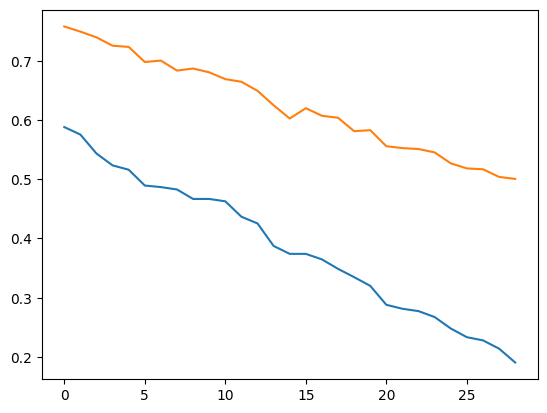

In [25]:

for col in ["total", "allmini"]:#, "llama"]:
    plt.plot(range(len(scores)), df[col])
plt.plot()

In [ ]:
# To look for systematic differnces, plot certain types

def plot_with_lines_showing_keywords(keyword):
    # Plot the specified columns
    for col in ["total", "allmini"]:#, "llama"]:
        plt.plot(range(len(scores)), (df[col]-min(df[col]))/(max(df[col])-min(df[col])), label=col)

    # Add gray vertical lines for rows where index contains "XX"
    for i, idx in enumerate(df.index):
        if keyword in str(idx):
            plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.8)

    plt.legend(title=keyword)
    plt.show()

plot_with_lines_showing_keywords("GPT")
plot_with_lines_showing_keywords("Llama")
plot_with_lines_showing_keywords("Mistral")
plot_with_lines_showing_keywords(" A")
plot_with_lines_showing_keywords(" B")
plot_with_lines_showing_keywords("Onto")
plot_with_lines_showing_keywords("Full")
plot_with_lines_showing_keywords("RAG")
plot_with_lines_showing_keywords("Retrieval")



[]

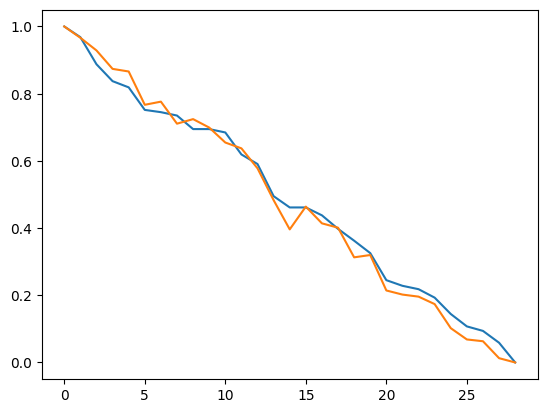

In [26]:

for col in ["total", "allmini"]:#, "llama"]:

    # original
    #plt.plot(range(len(scores)), df[col])
    # normalized
    plt.plot(range(len(scores)), (df[col]-min(df[col]))/(max(df[col])-min(df[col])))

plt.plot()

## print latex table

In [27]:
lt = df.to_latex(float_format="%.3f")
lt = lt.replace("000 ", " ")
lt = lt.replace("_", " ")
lt = lt.replace("+", "&")
print(lt)

\begin{tabular}{lrrrrrrr}
\toprule
 & hardware 4 & organism part 5 & experimental designs 10 & assay by molecule 14 & study type 18 & total & allmini \\
\midrule
Pre-Meta & GPT-4o mini & 0.540 & 0.787 & 0.330 & 0.770 & 0.513 & 0.588 & 0.758 \\
Pre-Meta Onto & GPT-4o mini & 0.513 & 0.743 & 0.323 & 0.817 & 0.480 & 0.575 & 0.749 \\
Pre-Meta:2 & GPT-4o mini & 0.520 & 0.703 & 0.340 & 0.670 & 0.483 & 0.543 & 0.739 \\
Pre-Meta:3 & GPT-4o mini & 0.477 & 0.663 & 0.313 & 0.663 & 0.500 & 0.523 & 0.725 \\
Pre-Meta:5 & GPT-4o mini & 0.483 & 0.643 & 0.303 & 0.657 & 0.493 & 0.516 & 0.723 \\
Pre-Meta:8 & GPT-4o mini & 0.440 & 0.617 & 0.263 & 0.663 & 0.463 & 0.489 & 0.698 \\
Pre-Meta:12 & GPT-4o mini & 0.427 & 0.600 & 0.263 & 0.663 & 0.480 & 0.487 & 0.700 \\
Pre-Meta & Llama 8B & 0.390 & 0.710 & 0.220 & 0.723 & 0.370 & 0.483 & 0.683 \\
Pre-Meta:24 & GPT-4o mini & 0.363 & 0.583 & 0.297 & 0.667 & 0.423 & 0.467 & 0.687 \\
Vanilla RAG & GPT-4o mini & 0.323 & 0.673 & 0.343 & 0.627 & 0.367 & 0.467 & 0.680 \\

# sparse tag results

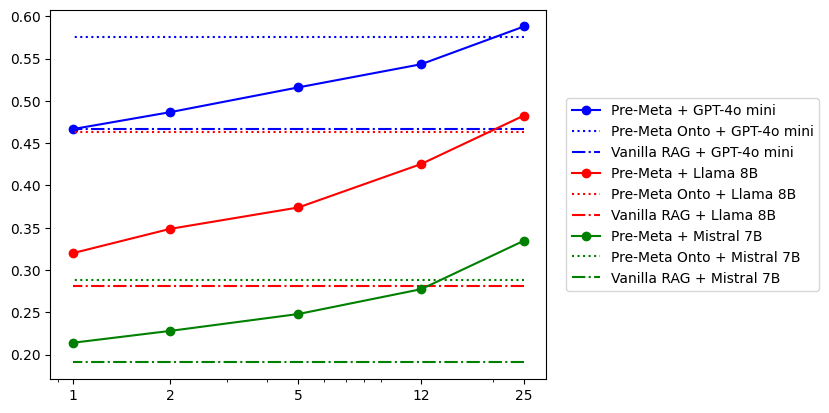

In [29]:
colors = "brgcmy"
for i, model in enumerate(["GPT-4o mini", 
                           "Llama 8B",
                           "Mistral 7B", 
                           ]):
    #for j, retriever in enumerate(["Pre-Meta A", "Pre-Meta B"]):
    for j, retriever in enumerate(["Pre-Meta"]):
        #print(retriever)
        linename = retriever + " + " + model
        linescores = []
        #ices = [1,2,3,4,5,6,8,12]#,24]
        #ices = [1,2,3,4,5,6,8,12,24]
        ices = [1,2,3,5,8,12,24]
        ices = [1,2,5,12,24]
        for ice in ices:
            #print(ice)
            ice_string = ":"+str(ice) if ice>1 else ""
            setupname = retriever+ice_string + " + " + model
            #print(setupname)
            score = df.loc[setupname]["total"]
            #print(score)
            linescores.append(score)
        
        #print(ices, linescores)

        #plt.plot(ices, linescores, color=colors[i])
        n_tags = [25//k for k in ices]
        plt.plot(n_tags, linescores, ["-o","-x"][j], label=linename, color=colors[i])


    for j, retriever in enumerate(["Pre-Meta Onto","Vanilla RAG"]):
        setupname = retriever + " + " + model
        score = df.loc[setupname]["total"]
        #plt.plot([ices[0], ices[-1]], [score, score], color=colors[i])
        plt.plot([n_tags[0], n_tags[-1]], [score, score], linestyle=["dotted","dashdot"][j], label=setupname, color=colors[i])

    if i<2:#i==1:
        continue # mistral+llama on same
    plt.xscale("log")
    ax = plt.gca()
    ax.set_xticks(n_tags)
    ax.set_xticklabels(n_tags)


    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


In [30]:
df

hardware_4  organism_part_5  \
Pre-Meta + GPT-4o mini         0.540000         0.786667   
Pre-Meta Onto + GPT-4o mini    0.513333         0.743333   
Pre-Meta:2 + GPT-4o mini       0.520000         0.703333   
Pre-Meta:3 + GPT-4o mini       0.476667         0.663333   
Pre-Meta:5 + GPT-4o mini       0.483333         0.643333   
Pre-Meta:8 + GPT-4o mini       0.440000         0.616667   
Pre-Meta:12 + GPT-4o mini      0.426667         0.600000   
Pre-Meta + Llama 8B            0.390000         0.710000   
Pre-Meta:24 + GPT-4o mini      0.363333         0.583333   
Vanilla RAG + GPT-4o mini      0.323333         0.673333   
Pre-Meta Onto + Llama 8B       0.410000         0.593333   
Fullpaper + GPT-4o mini        0.340000         0.730000   
Pre-Meta:2 + Llama 8B          0.403333         0.553333   
Pre-Meta:3 + Llama 8B          0.373333         0.490000   
Pre-Meta Retrieval             0.110000         0.546667   
Pre-Meta:5 + Llama 8B          0.356667         0.423333   
Pre-Meta:8 + Llama 8B          0.323333         0.413333   
Pre-Meta:12 + Llama 8B         0.306667         0.396667   
Pre-Meta + Mistral 7B          0.190000         0.560000   
Pre-Meta:24 + Llama 8B         0.243333         0.343333   
Pre-Meta Onto + Mistral 7B     0.166667         0.413333   
Vanilla RAG + Llama 8B         0.170000         0.483333   
Pre-Meta:2 + Mistral 7B        0.170000         0.406667   
Pre-Meta:3 + Mistral 7B        0.163333         0.363333   
Pre-Meta:5 + Mistral 7B        0.163333         0.296667   
Pre-Meta:8 + Mistral 7B        0.133333         0.246667   
Pre-Meta:12 + Mistral 7B       0.126667         0.236667   
Pre-Meta:24 + Mistral 7B       0.133333         0.160000   
Vanilla RAG + Mistral 7B       0.063333         0.260000   

                             experimental_designs_10  assay_by_molecule_14  \
Pre-Meta + GPT-4o mini                      0.330000              0.770000   
Pre-Meta Onto + GPT-4o mini                 0.323333              0.816667   
Pre-Meta:2 + GPT-4o mini                    0.340000              0.670000   
Pre-Meta:3 + GPT-4o mini                    0.313333              0.663333   
Pre-Meta:5 + GPT-4o mini                    0.303333              0.656667   
Pre-Meta:8 + GPT-4o mini                    0.263333              0.663333   
Pre-Meta:12 + GPT-4o mini                   0.263333              0.663333   
Pre-Meta + Llama 8B                         0.220000              0.723333   
Pre-Meta:24 + GPT-4o mini                   0.296667              0.666667   
Vanilla RAG + GPT-4o mini                   0.343333              0.626667   
Pre-Meta Onto + Llama 8B                    0.180000              0.740000   
Fullpaper + GPT-4o mini                     0.160000              0.683333   
Pre-Meta:2 + Llama 8B                       0.233333              0.516667   
Pre-Meta:3 + Llama 8B                       0.170000              0.550000   
Pre-Meta Retrieval                          0.170000              0.740000   
Pre-Meta:5 + Llama 8B                       0.180000              0.526667   
Pre-Meta:8 + Llama 8B                       0.186667              0.550000   
Pre-Meta:12 + Llama 8B                      0.166667              0.550000   
Pre-Meta + Mistral 7B                       0.156667              0.626667   
Pre-Meta:24 + Llama 8B                      0.180000              0.526667   
Pre-Meta Onto + Mistral 7B                  0.093333              0.643333   
Vanilla RAG + Llama 8B                      0.123333              0.490000   
Pre-Meta:2 + Mistral 7B                     0.116667              0.550000   
Pre-Meta:3 + Mistral 7B                     0.086667              0.570000   
Pre-Meta:5 + Mistral 7B                     0.096667              0.566667   
Pre-Meta:8 + Mistral 7B                     0.093333              0.570000   
Pre-Meta:12 + Mistral 7B                    0.103333              0.566667   
Pre-Meta:24 + Mistral 7B                    

## index plots

In [31]:
label_idx = {}
pred_idx = {}
label_idx_am = {}
pred_idx_am = {}

for argstring in index_data:
    label_idx[argstring] = []
    pred_idx[argstring] = []
    label_idx_am[argstring] = []
    pred_idx_am[argstring] = []
    #print(argstring)
    for field in index_data[argstring]:
        if field!="assay_by_molecule_14":
            for x,y in index_data[argstring][field]:
                label_idx[argstring].append(x)
                pred_idx[argstring].append(y)
        else:
            for x,y in index_data[argstring][field]:
                label_idx_am[argstring].append(x)
                pred_idx_am[argstring].append(y)


In [32]:
from matplotlib import pyplot as plt

### plot number of predictions of each index, for each setup

takeaways: all generation models prefer early choices, mistral really prefers the first one

First, all retrievals method with same generation method is added together.
Below that is each individual setup.

Mistral-7B
10800.0


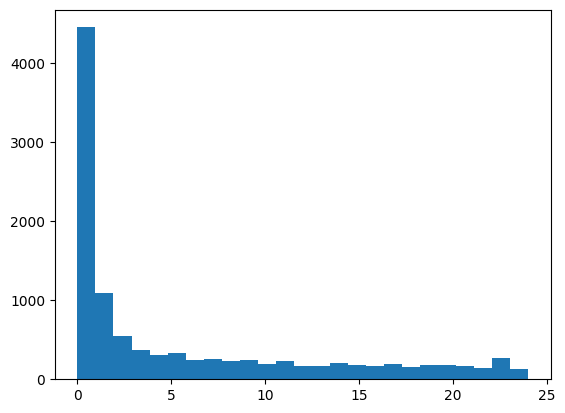

Meta-Llama-3.1
10800.0


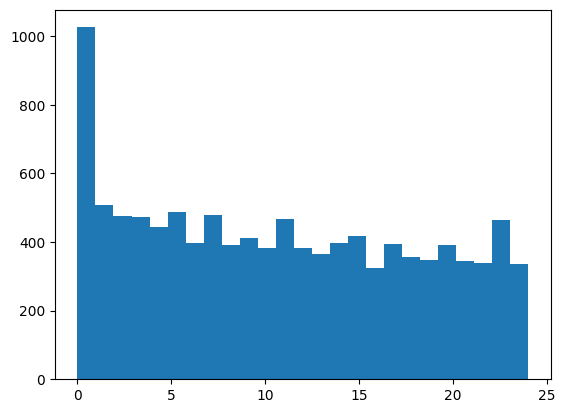

4om
11999.0


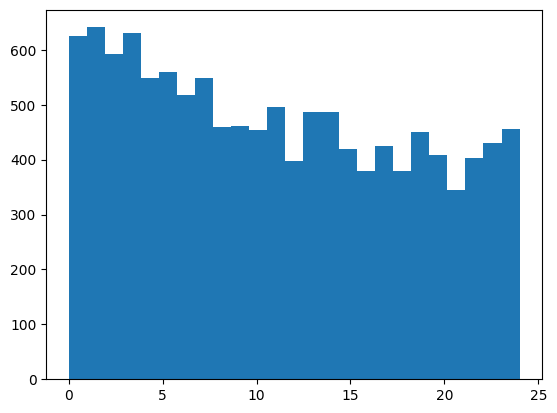

best_choice
1200.0


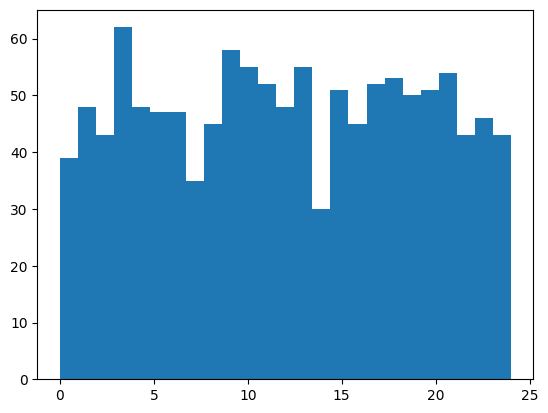

In [33]:
for term in ["Mistral-7B", 
             "Meta-Llama-3.1", 
             "4om", 
             #"DeepSeek", 
             "best_choice"]:
    label_counts = np.zeros(25)
    pred_counts = np.zeros(25)

    for argstring in index_data:
        if term in argstring:
            for val in label_idx[argstring]:
                label_counts[val] += 1
            for val in pred_idx[argstring]:
                pred_counts[val] += 1

    print(term)
    print(sum(pred_counts))
    #plt.plot(pred_counts/label_counts, "x")
    #plt.show()

    #plt.hist(x=list(range(25)), weights=pred_counts/label_counts, bins=25)
    #plt.hist(x=list(range(25)), weights=label_counts, bins=25)#, alpha=0.5)
    plt.hist(x=list(range(25)), weights=pred_counts, bins=25)#, alpha=0.8)
    plt.show()
    


Mistral-7B
2700.0


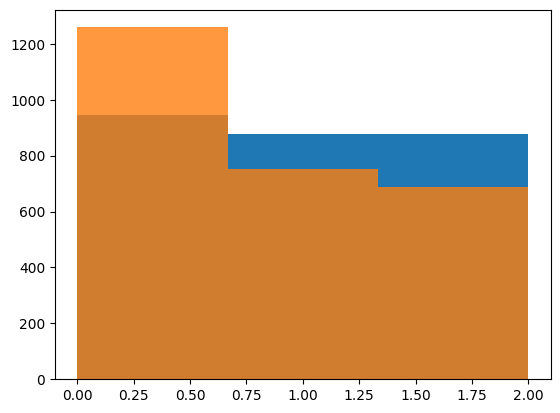

Meta-Llama-3.1
2700.0


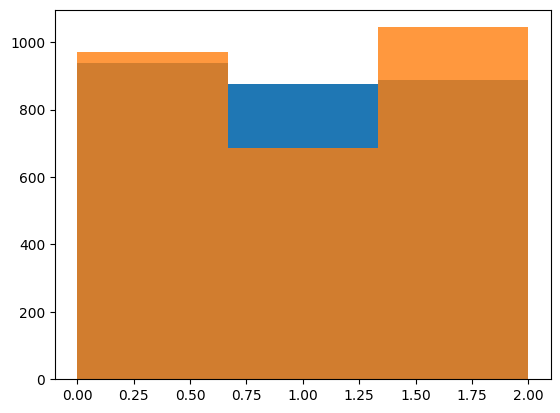

4om
3000.0


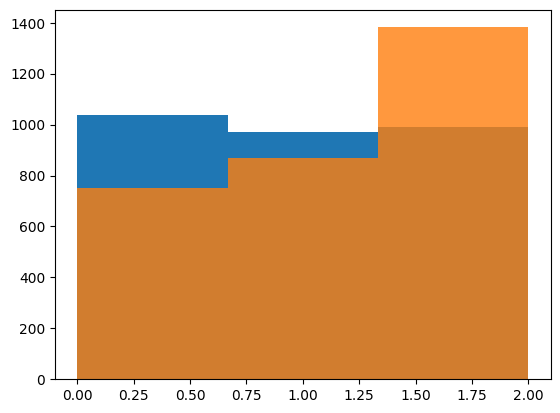

In [34]:
for term in ["Mistral-7B", "Meta-Llama-3.1", "4om"]:
    label_counts = np.zeros(3)
    pred_counts = np.zeros(3)

    for argstring in index_data:
        if term in argstring:
            for val in label_idx_am[argstring]:
                label_counts[val] += 1
            for val in pred_idx_am[argstring]:
                pred_counts[val] += 1
        
    print(term)
    print(sum(pred_counts))
    #plt.plot(pred_counts/label_counts, "x")
    #plt.show()

    #plt.hist(x=list(range(3)), weights=pred_counts/label_counts, bins=3)
    plt.hist(x=list(range(3)), weights=label_counts, bins=3)#, alpha=0.5)
    plt.hist(x=list(range(3)), weights=pred_counts, bins=3, alpha=0.8)
    plt.show()
    


Pre-Meta Retrieval
1200.0


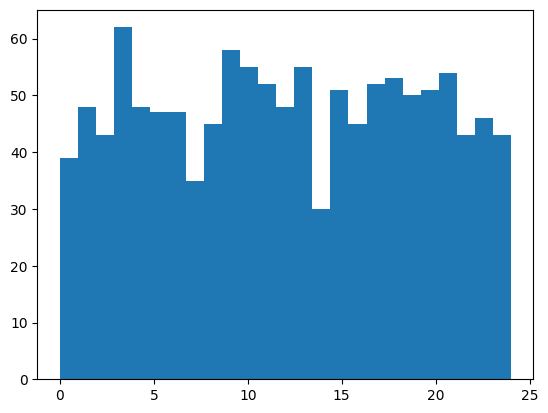

Vanilla RAG + GPT-4o mini
1200.0


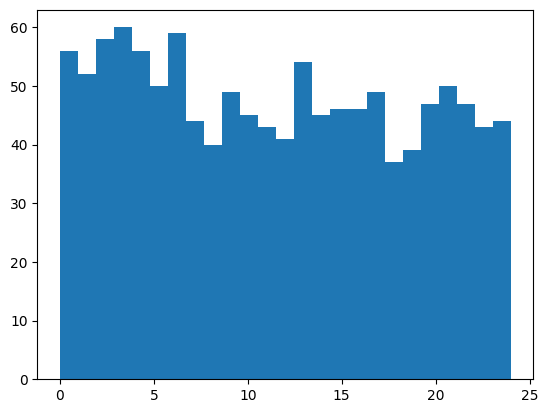

Pre-Meta + GPT-4o mini
1200.0


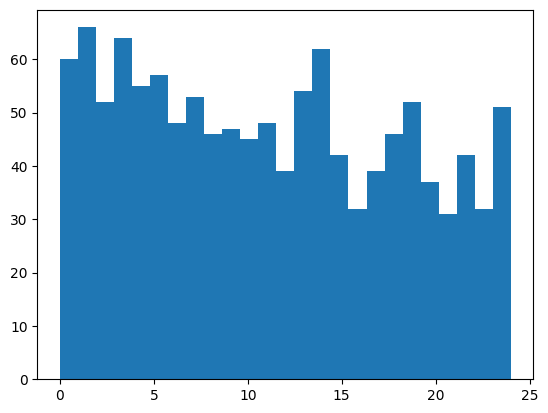

Pre-Meta:2 + GPT-4o mini
1200.0


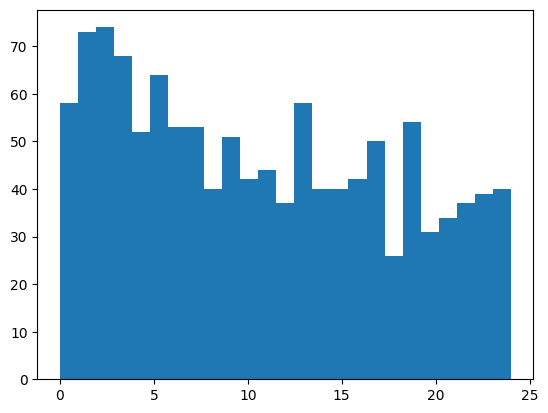

Pre-Meta:3 + GPT-4o mini
1200.0


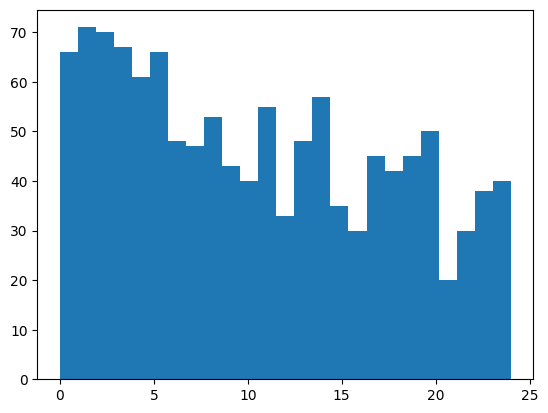

Pre-Meta:5 + GPT-4o mini
1200.0


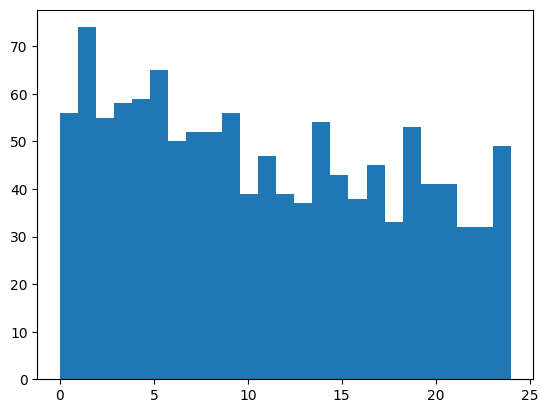

Pre-Meta:8 + GPT-4o mini
1200.0


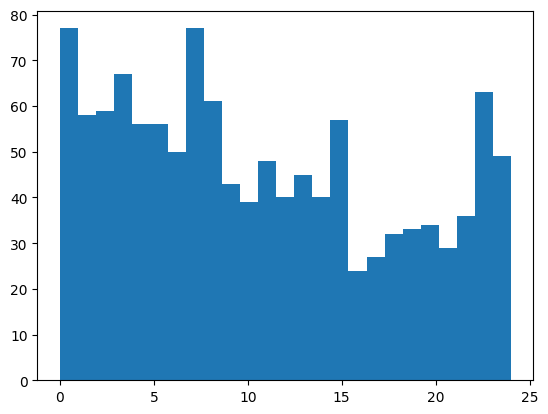

Pre-Meta:12 + GPT-4o mini
1200.0


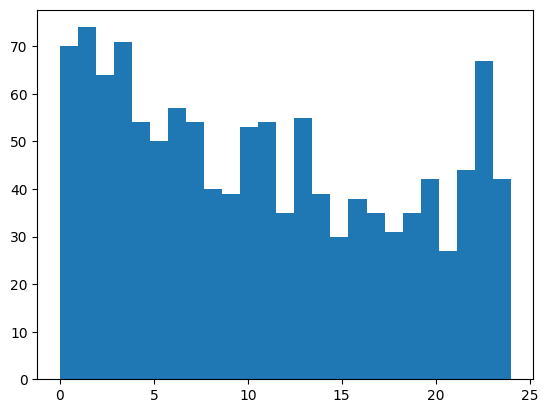

Pre-Meta:24 + GPT-4o mini
1200.0


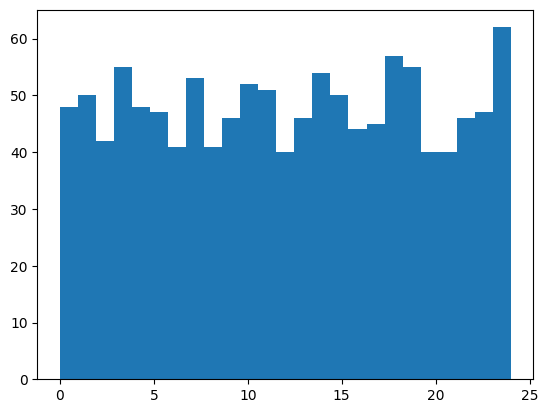

Fullpaper + GPT-4o mini
1199.0


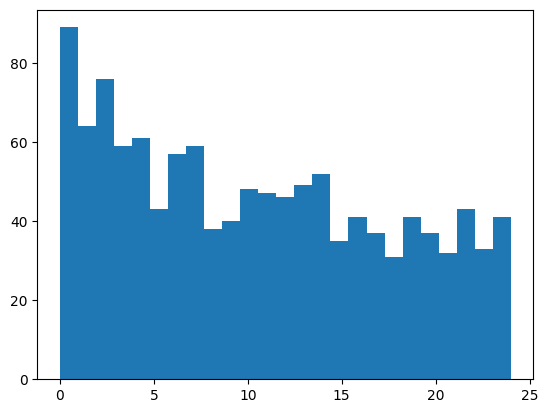

Pre-Meta Onto + GPT-4o mini
1200.0


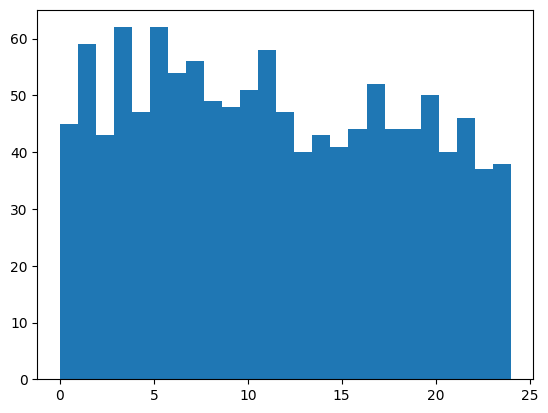

Pre-Meta + Llama 8B
1200.0


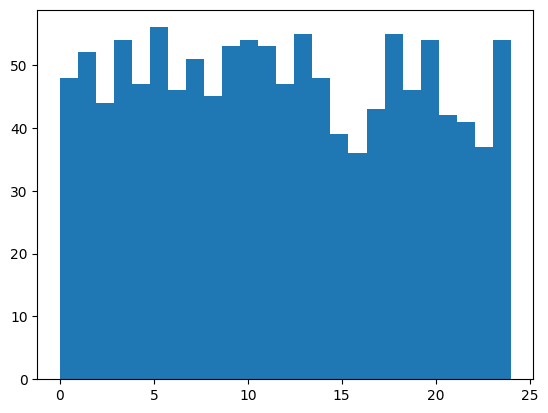

Pre-Meta:2 + Llama 8B
1200.0


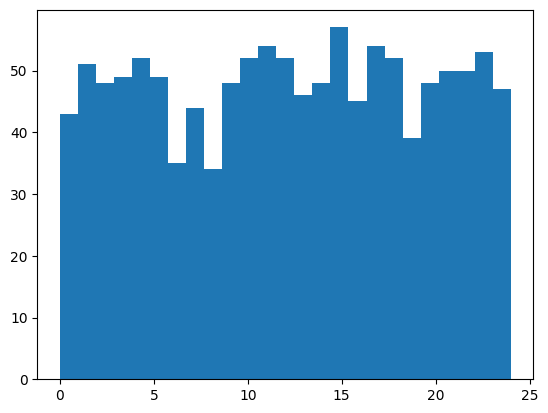

Pre-Meta:3 + Llama 8B
1200.0


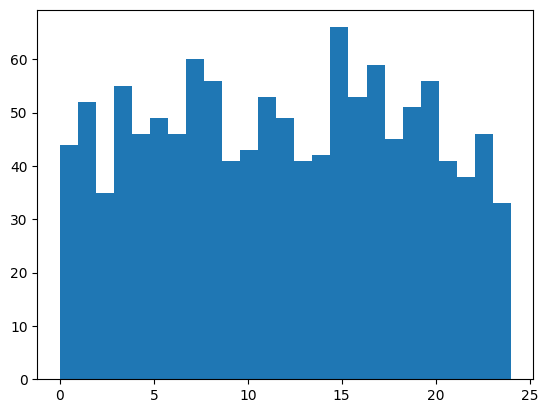

Pre-Meta:5 + Llama 8B
1200.0


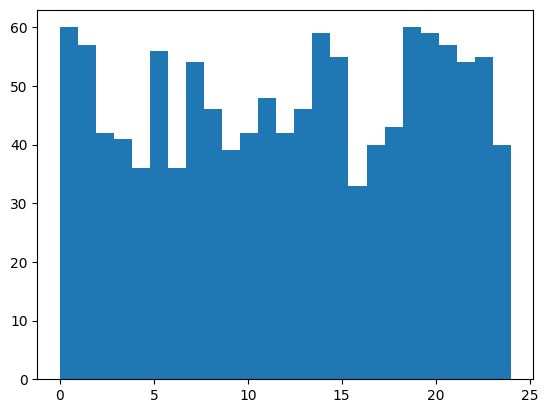

Pre-Meta:8 + Llama 8B
1200.0


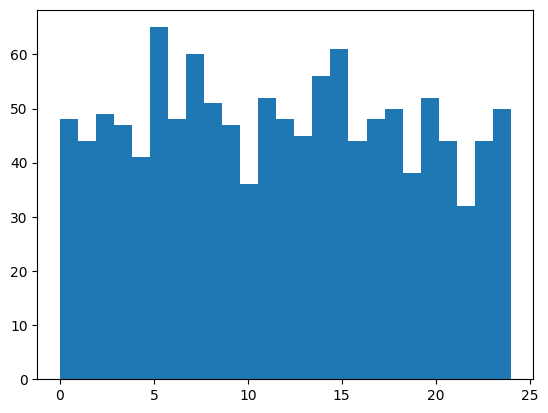

Pre-Meta:12 + Llama 8B
1200.0


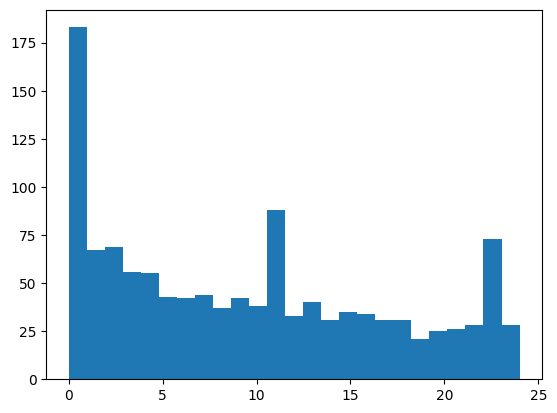

Pre-Meta:24 + Llama 8B
1200.0


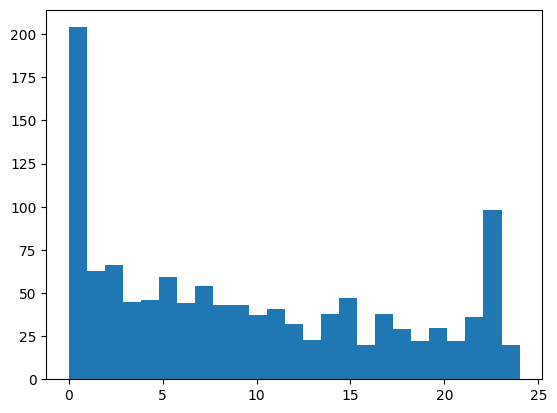

Pre-Meta + Mistral 7B
1200.0


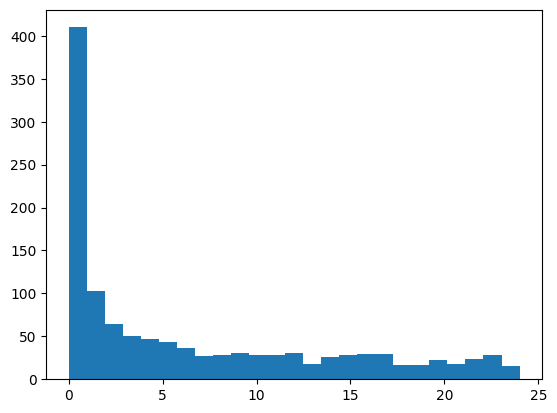

Pre-Meta:2 + Mistral 7B
1200.0


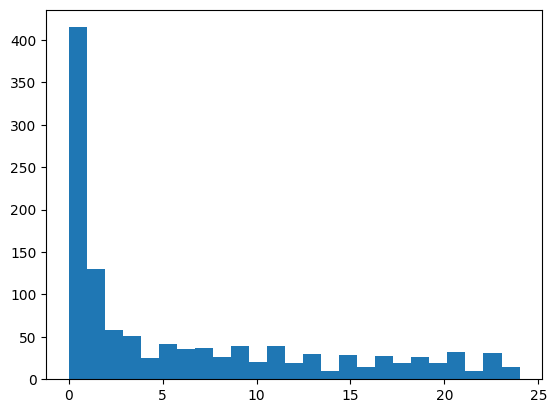

Pre-Meta:3 + Mistral 7B
1200.0


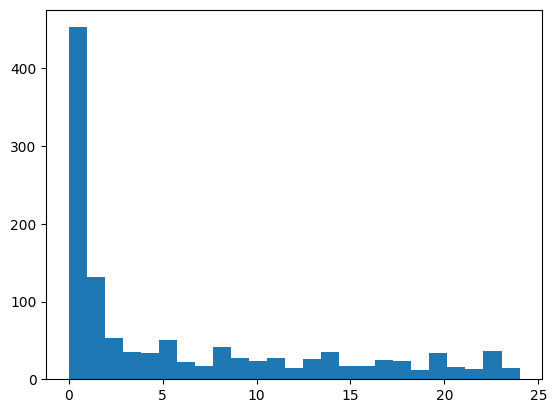

Pre-Meta:5 + Mistral 7B
1200.0


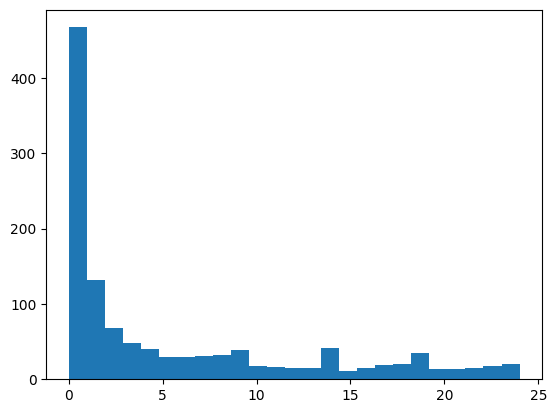

Pre-Meta:8 + Mistral 7B
1200.0


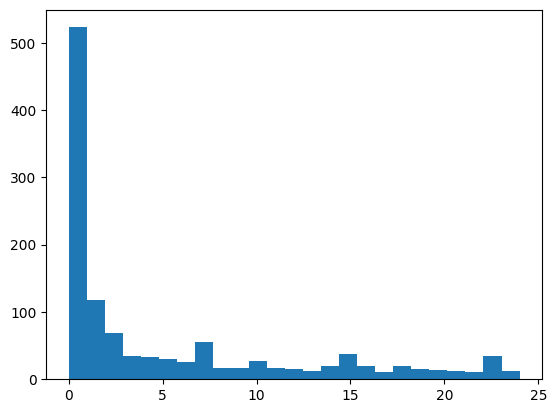

Pre-Meta:12 + Mistral 7B
1200.0


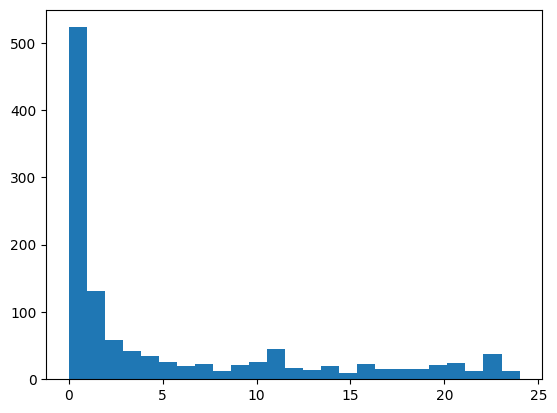

Pre-Meta:24 + Mistral 7B
1200.0


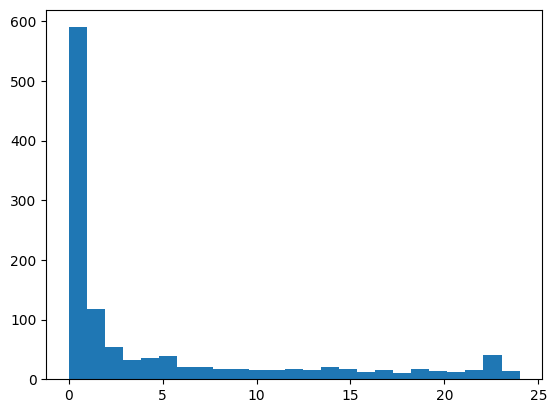

Vanilla RAG + Llama 8B
1200.0


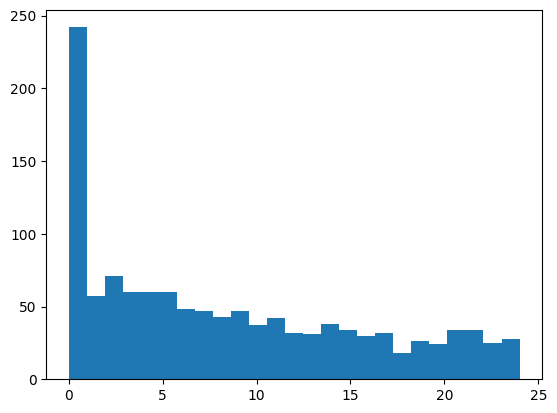

Vanilla RAG + Mistral 7B
1200.0


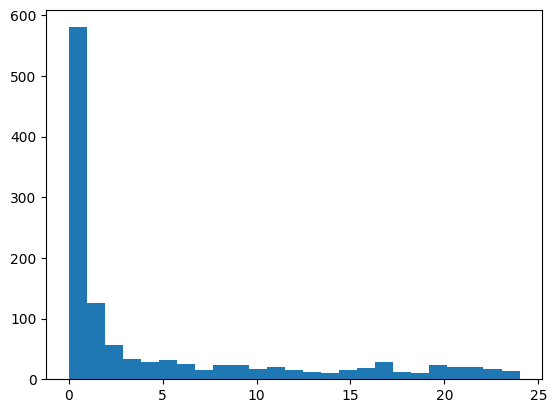

Pre-Meta Onto + Llama 8B
1200.0


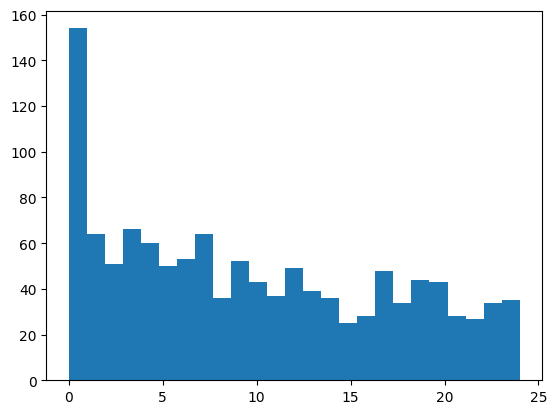

Pre-Meta Onto + Mistral 7B
1200.0


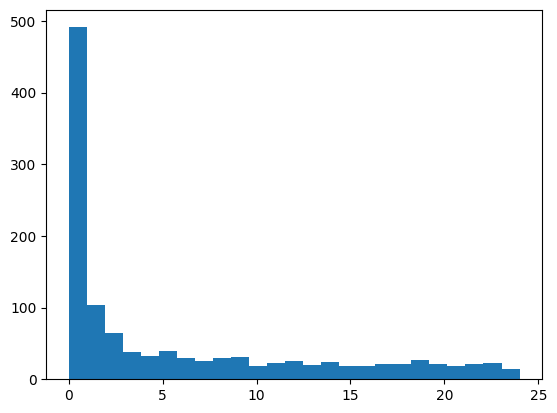

In [35]:
for argstring in index_data:
    label_counts = np.zeros(25)
    pred_counts = np.zeros(25)
    for val in label_idx[argstring]:
        label_counts[val] += 1
    for val in pred_idx[argstring]:
        pred_counts[val] += 1
        
    print(shortnames_by_argstring[argstring])
    print(sum(pred_counts))
    #plt.plot(pred_counts/label_counts, "x")
    #plt.show()

    #plt.hist(x=list(range(25)), weights=pred_counts/label_counts, bins=25)
    plt.hist(x=list(range(25)), weights=pred_counts, bins=25)
    plt.show()
    


# Choices

now we plot number of times each answer was predicted, as well as the distribution of correct answers.

This is done for each field, for each model/setup, so there is a lot of plots.

the blue is the distribution of correct answers, the orange the predicted ones. Good prediction should overlap the blue plot.

This gives a way of checking if the generation model prefers certain answers. If, for example, one of the answers is a much more common word, the model might have an artificially high probability of choosing that answer. But it seems they are quite evenly destrivbuted in most cases.


some mentionable takeaways are
- best_choice has a high preference for certain answers. I guess this means the embeddings of these answers are closer to a typical chunk of text, whatever that means?
- in organism_part, "peripheral blood" is choosen way to often, and "blood" way to rarely (for all models). A possible explanation is semantic overlap among the labels - many of the cases labeled blood could have been labeled peripheral blood, and vice versa, and the models prefer the more specific variant when appropriate.
  - for gpt, the majority of the errors in this field comes from these two answers, indicating that gpt is likely better than the numbers indicate (i.e. labels are not (much) more accurate than predictions)
- gpt does not seem to have a big preference for certain words.
- llama and mistral really prefers certain words, e.g. spleen for organism part, certain designs types and one hardware choice. This really hinders performance. Perhaps chaging decoding (e.g. temperature, or n_beams for beam search) could help.
  - for some reason, "choices-mistral" does not prefer spleen like the other versions


In [36]:
# get all field names
import metadata_schemas
schema = metadata_schemas.get_shuffled_arxpr2(25, v3=True)()

names =schema.__fields__
#names = names[0].
for field in names:
    print(list(schema.__fields__[field].annotation.__args__))


['illumina hiseq 2000', 'illumina hiseq 2500', 'illumina genome analyzer ii', 'illumina genome analyzer iix', 'illumina hiseq 4000', 'nextseq 500', 'illumina novaseq 6000', 'illumina miseq', 'illumina hiseq 1000', 'illumina genome analyzer', 'affymetrix genechip scanner 3000 7g', 'illumina hiseq 1500', 'ab solid 4 system', 'axon- genepix4000b', 'axon genepix 4000b scanning hardware', '418 [affymetrix]', 'scanning hardware', 'illumina hiscansq', 'genepix 4000b [axon instruments]', 'g2565ba dna microarray scanner [agilent]', 'genepix 4000a [axon instruments]', 'ab solid system 3.0', 'illumina hiseq 3000', 'nextseq 550', 'genepix personal 4100a [axon instruments]']
['liver', 'blood', 'whole organism', 'leaf', 'bone marrow', 'lung', 'brain', 'skin', 'peripheral blood', 'kidney', 'spleen', 'breast', 'colon', 'heart', 'whole blood', 'mammary gland', 'root', 'hippocampus', 'pancreas', 'testis', 'retina', 'embryo', 'prostate', 'whole embryo', 'spinal cord']
['transcription profiling by array',

In [37]:
schema.__fields__

{'hardware_4': FieldInfo(annotation=Literal['illumina hiseq 2000', 'illumina hiseq 2500', 'illumina genome analyzer ii', 'illumina genome analyzer iix', 'illumina hiseq 4000', 'nextseq 500', 'illumina novaseq 6000', 'illumina miseq', 'illumina hiseq 1000', 'illumina genome analyzer', 'affymetrix genechip scanner 3000 7g', 'illumina hiseq 1500', 'ab solid 4 system', 'axon- genepix4000b', 'axon genepix 4000b scanning hardware', '418 [affymetrix]', 'scanning hardware', 'illumina hiscansq', 'genepix 4000b [axon instruments]', 'g2565ba dna microarray scanner [agilent]', 'genepix 4000a [axon instruments]', 'ab solid system 3.0', 'illumina hiseq 3000', 'nextseq 550', 'genepix personal 4100a [axon instruments]'], required=True, description='Name of machine/techonology used for processing biosamples.'),
 'organism_part_5': FieldInfo(annotation=Literal['liver', 'blood', 'whole organism', 'leaf', 'bone marrow', 'lung', 'brain', 'skin', 'peripheral blood', 'kidney', 'spleen', 'breast', 'colon', 'h

Pre-Meta Retrieval


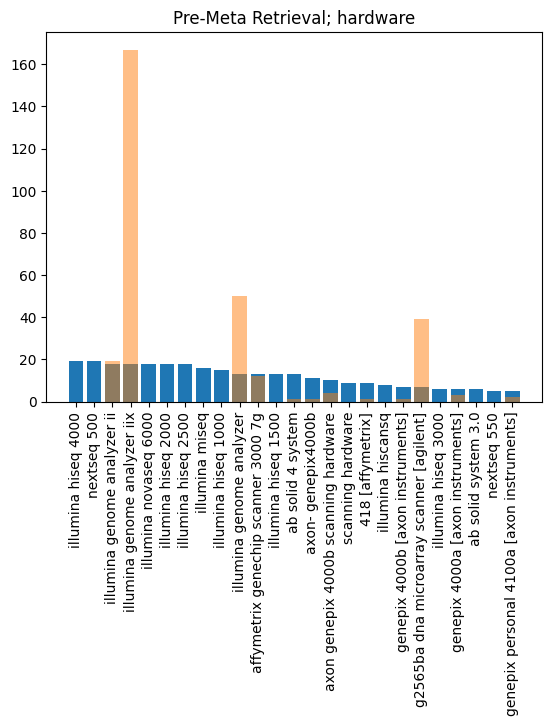

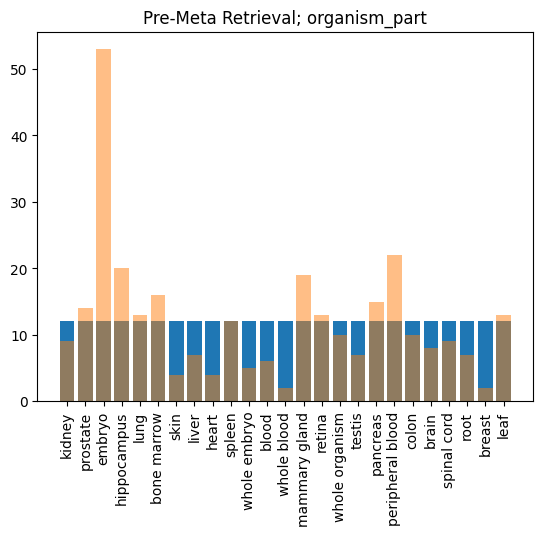

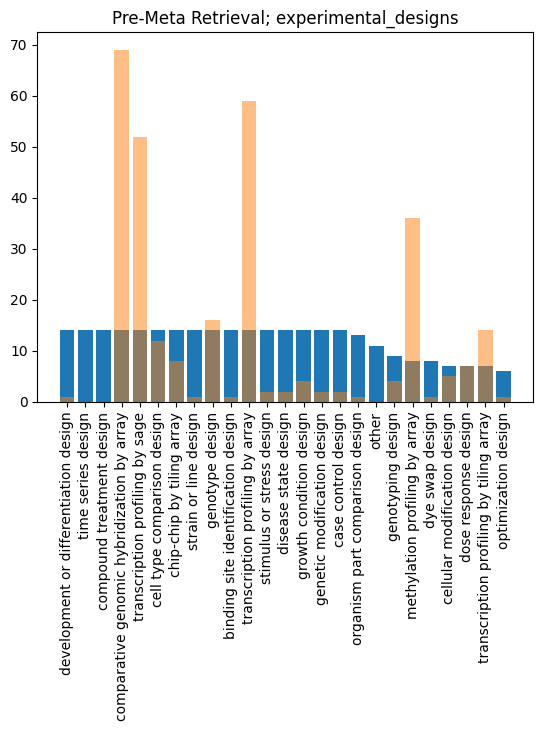

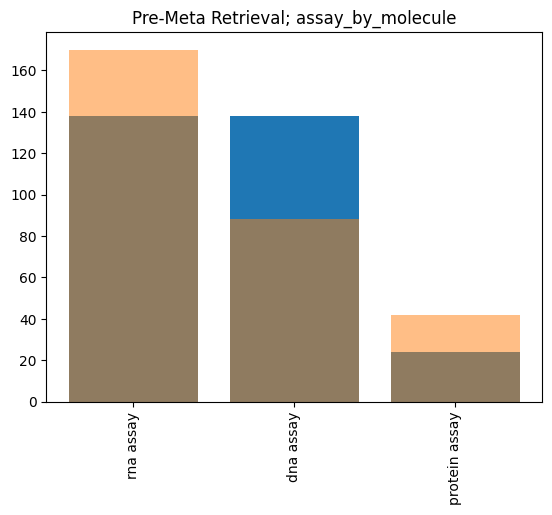

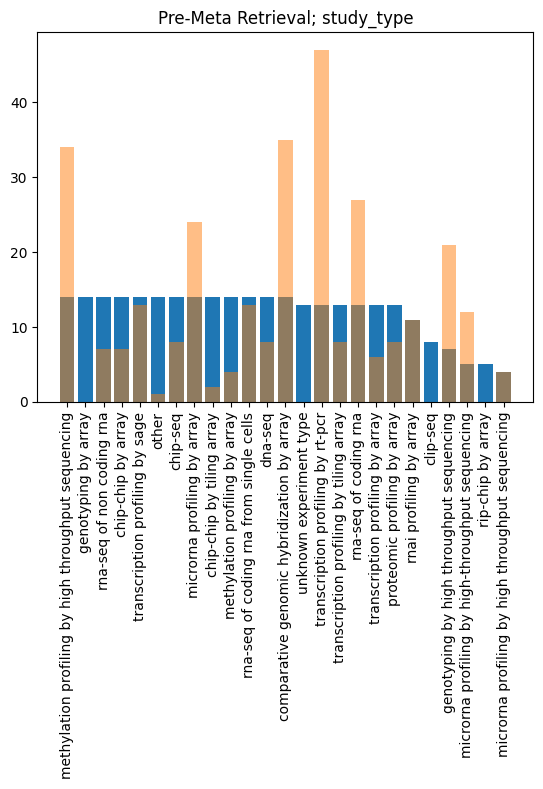

Vanilla RAG + GPT-4o mini


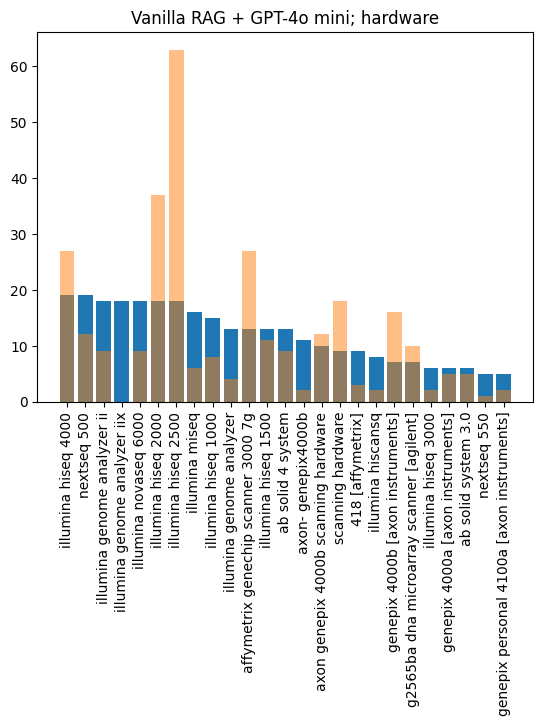

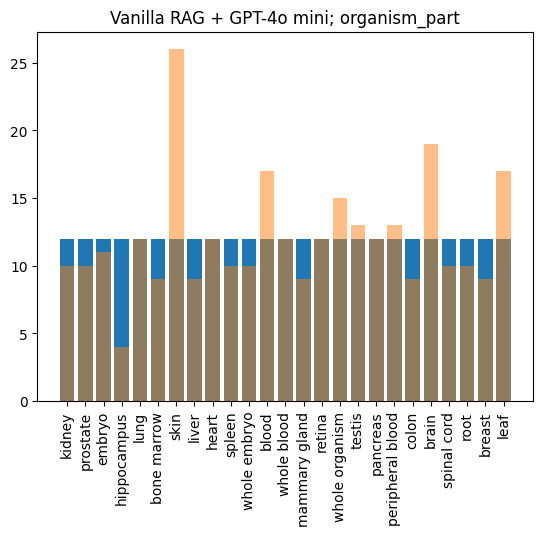

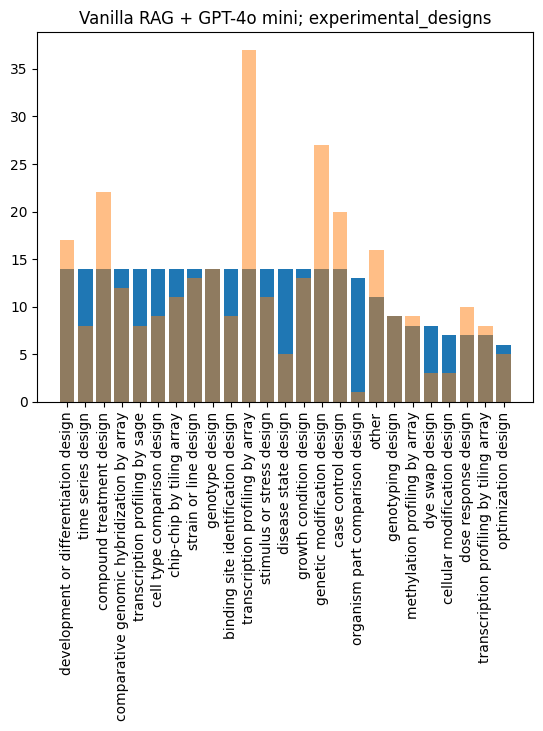

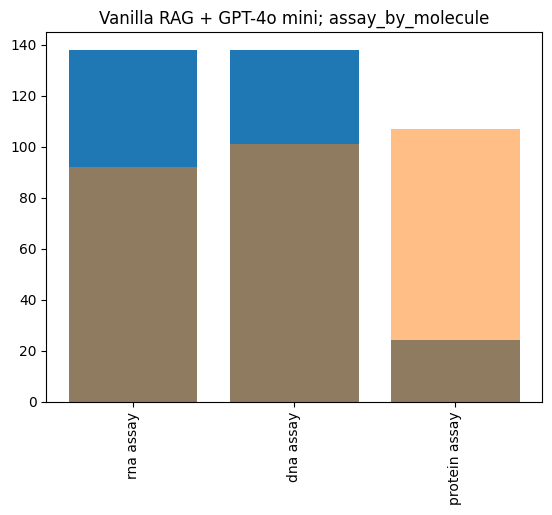

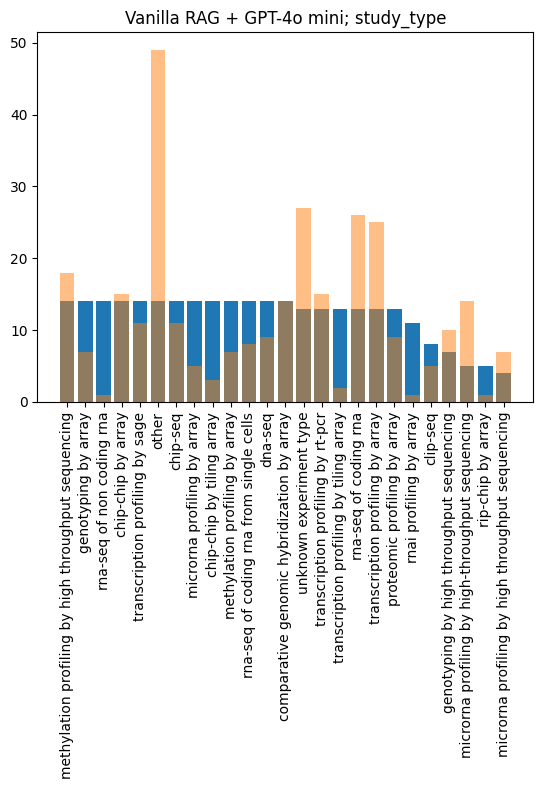

Pre-Meta + GPT-4o mini


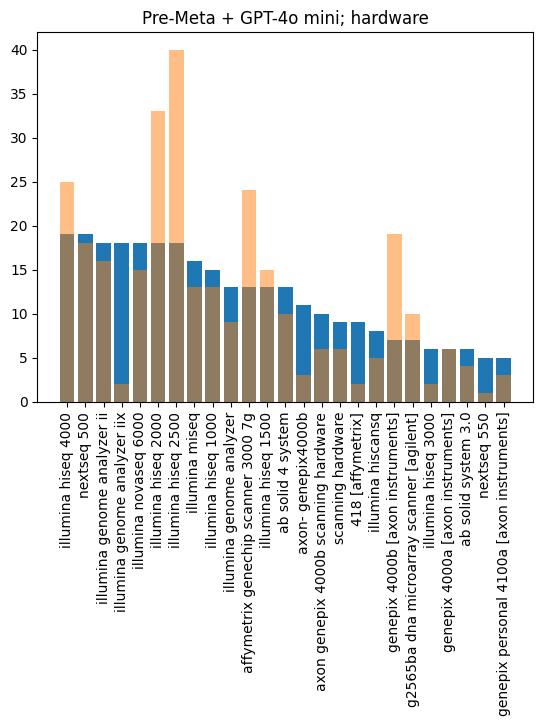

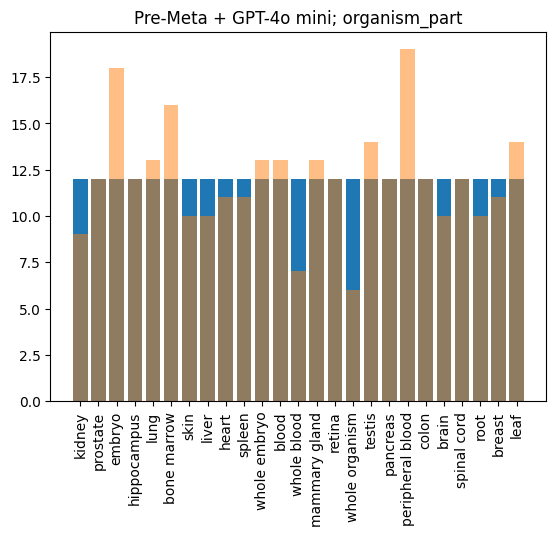

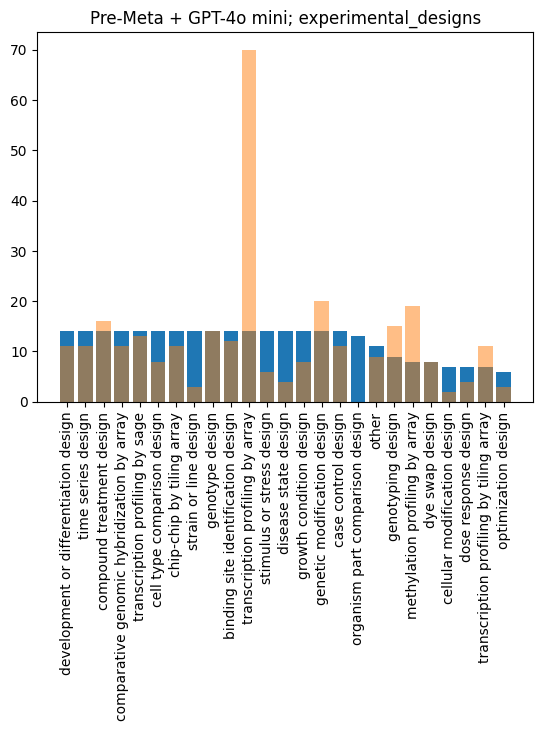

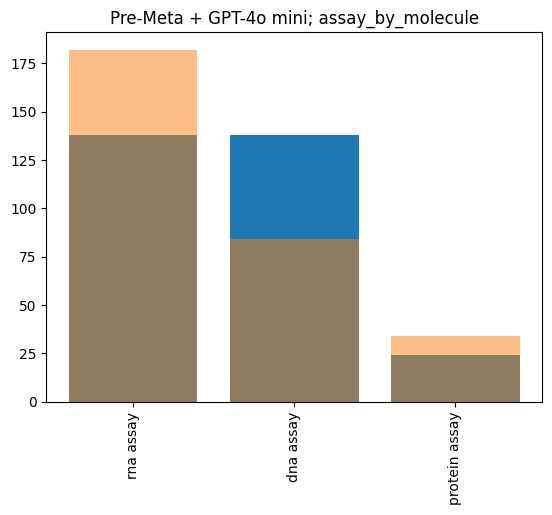

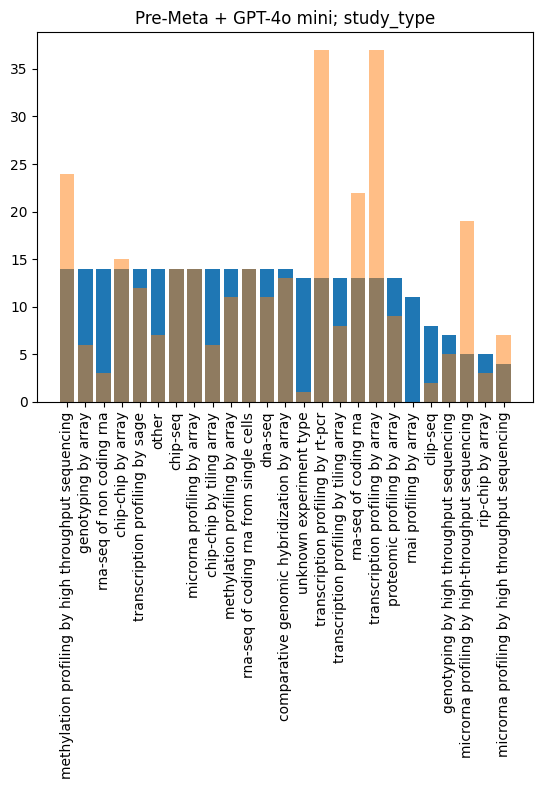

Fullpaper + GPT-4o mini


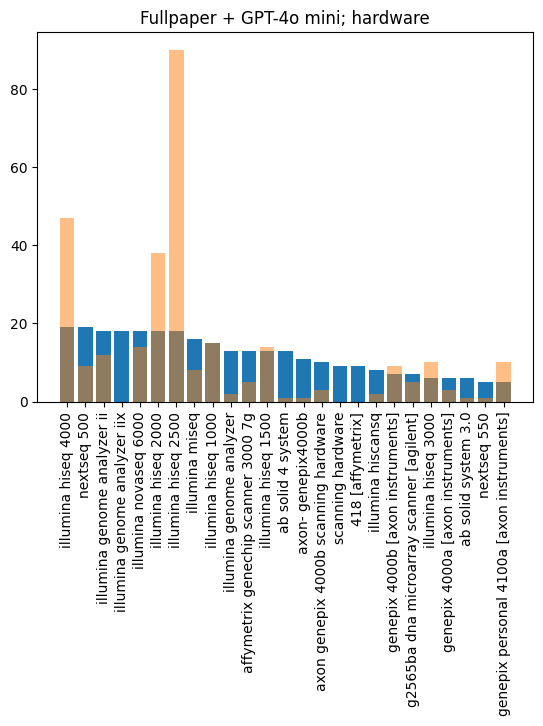

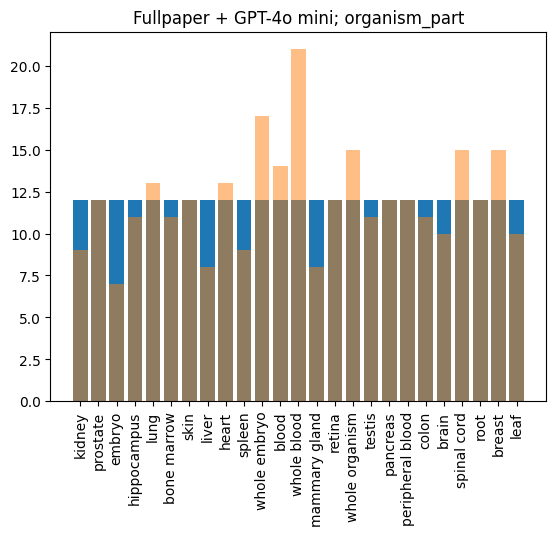

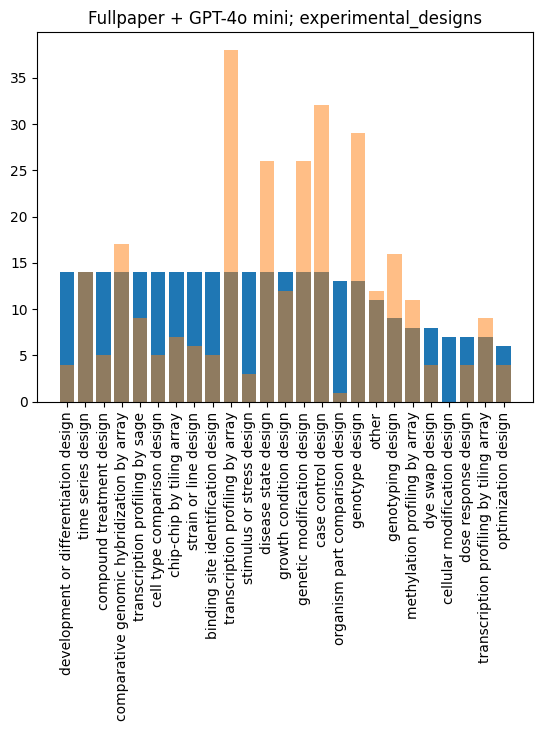

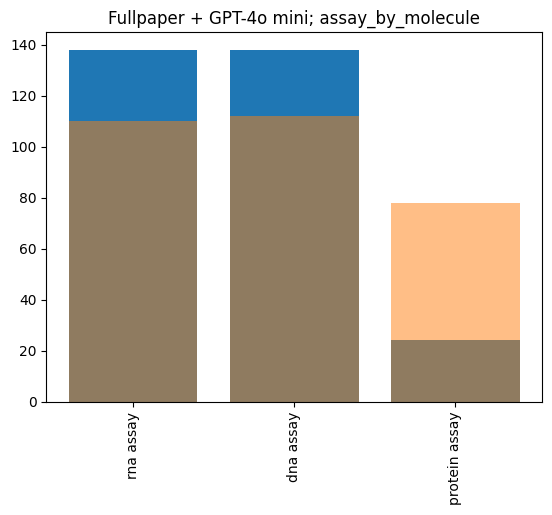

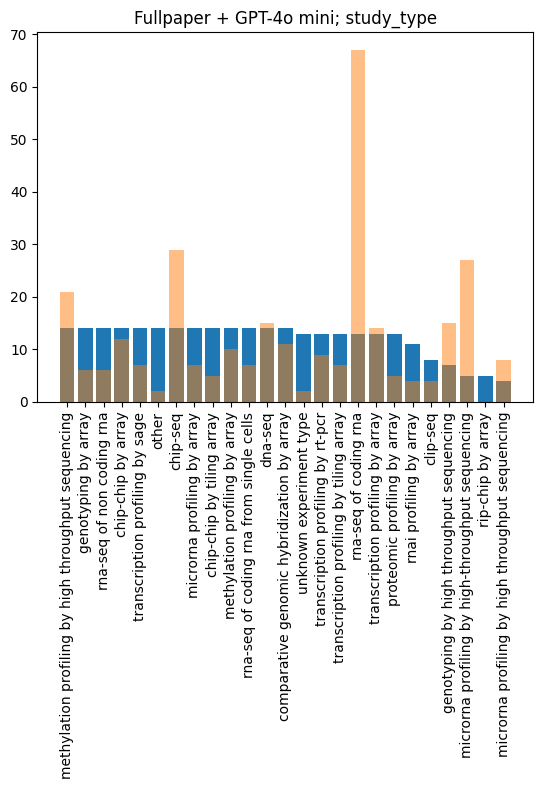

Pre-Meta Onto + GPT-4o mini


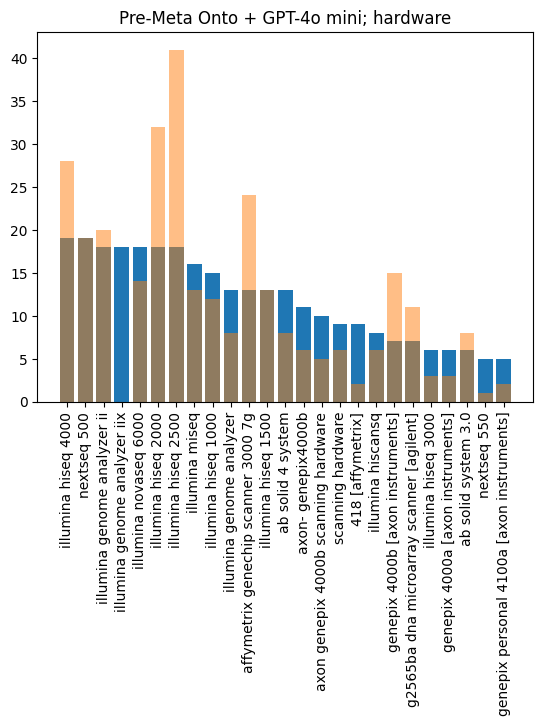

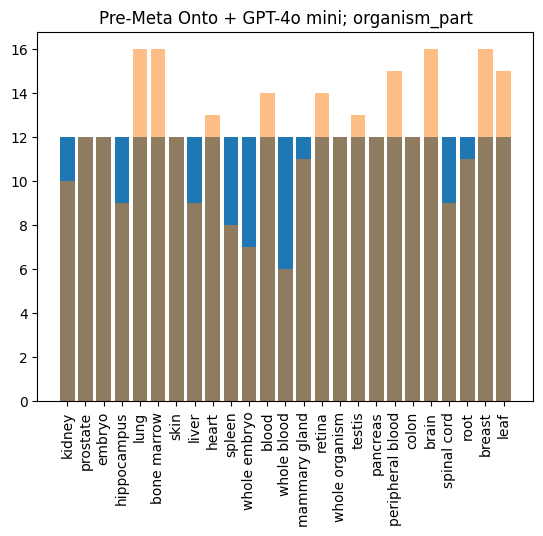

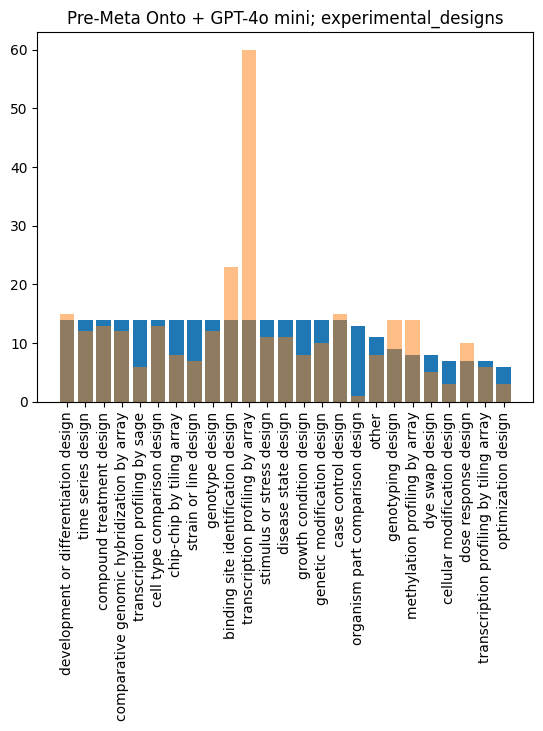

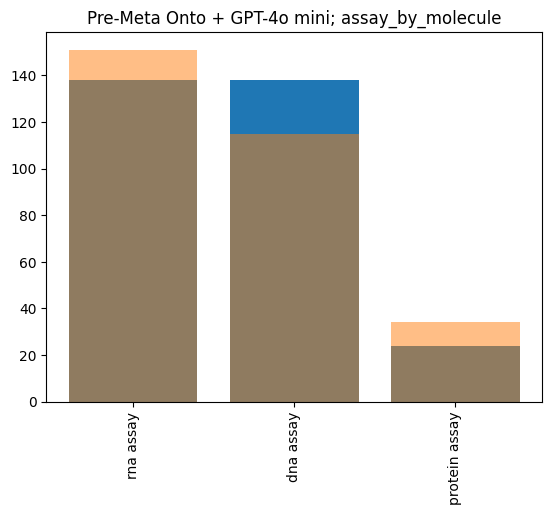

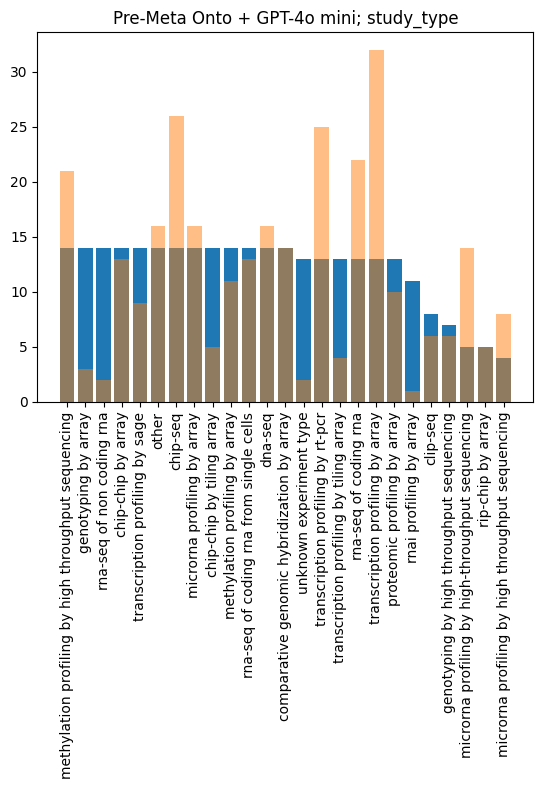

Pre-Meta + Llama 8B


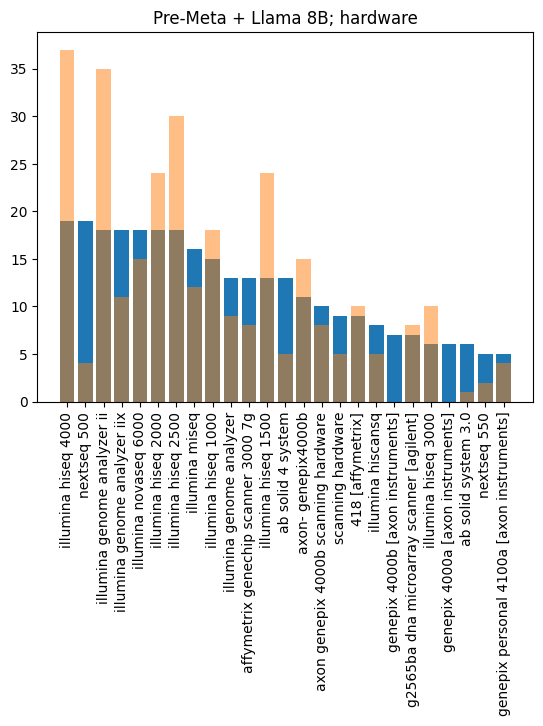

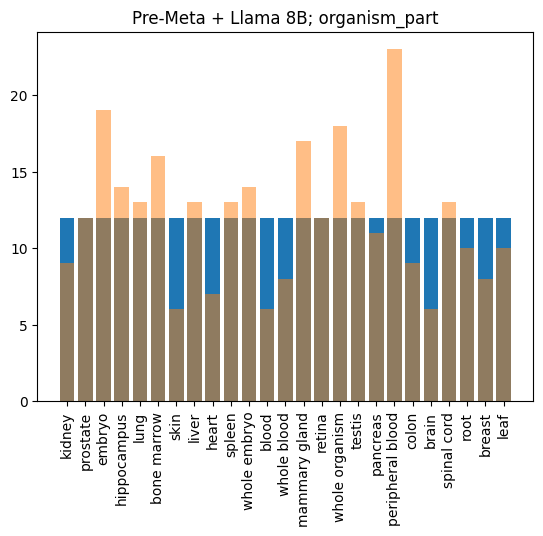

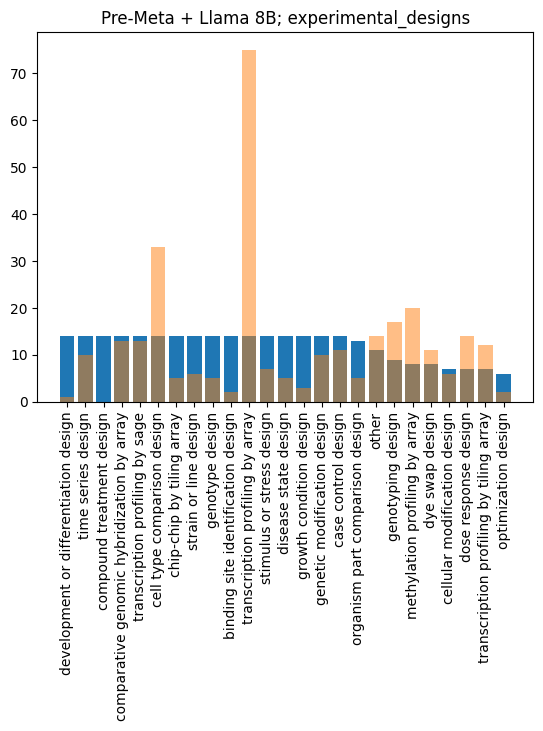

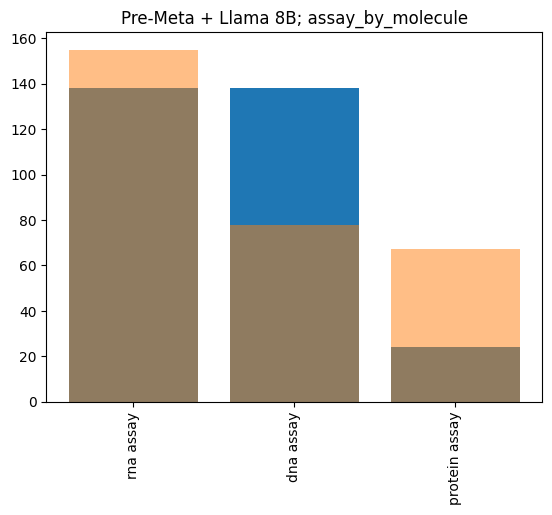

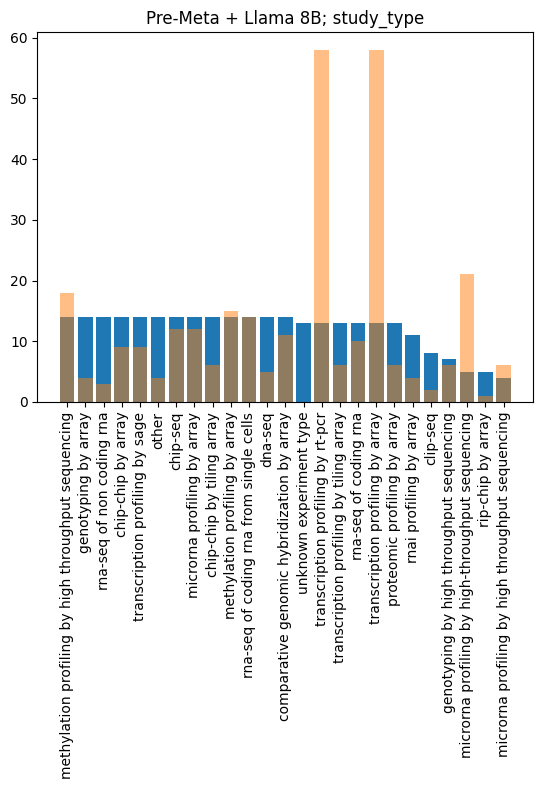

Pre-Meta + Mistral 7B


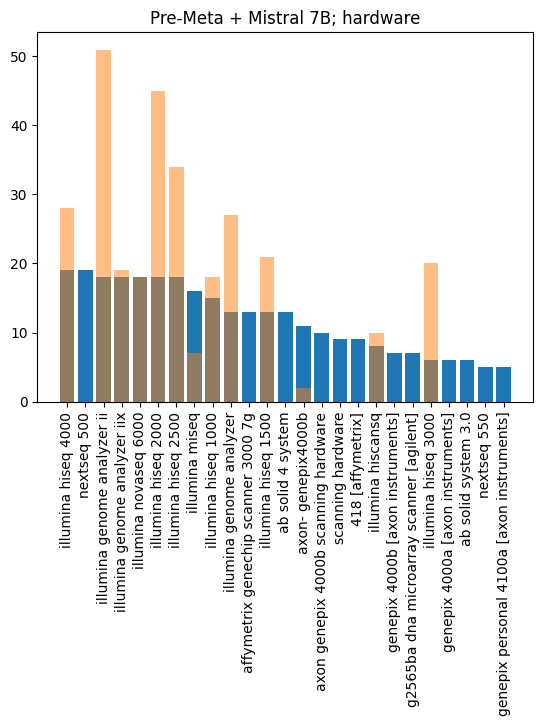

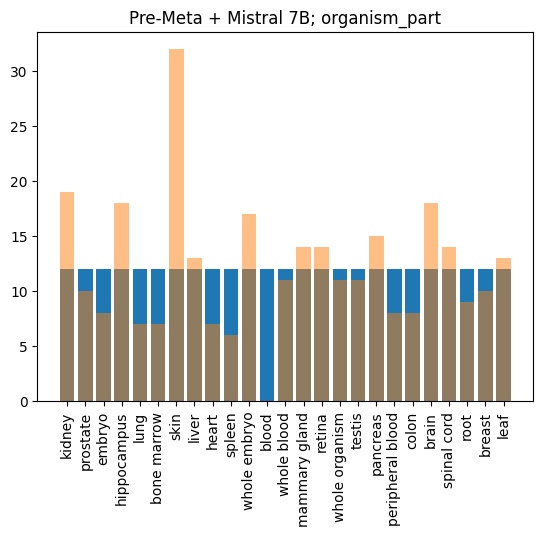

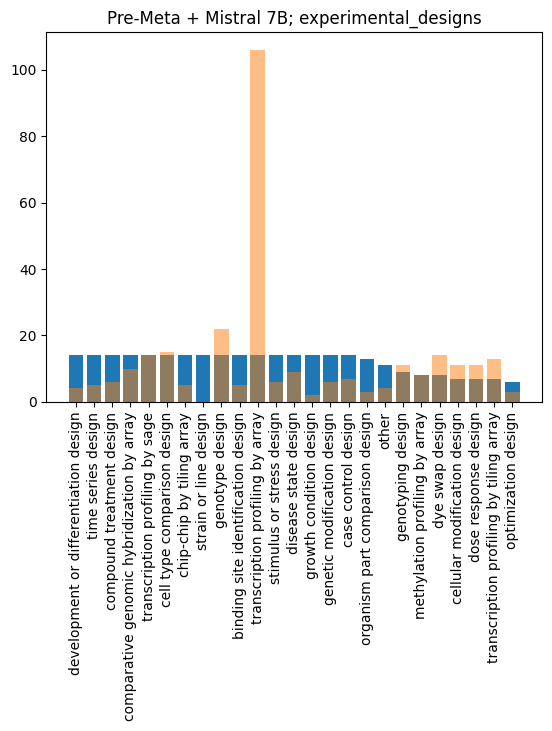

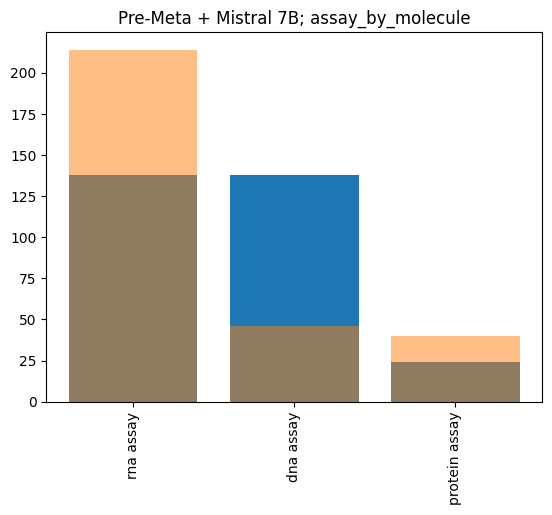

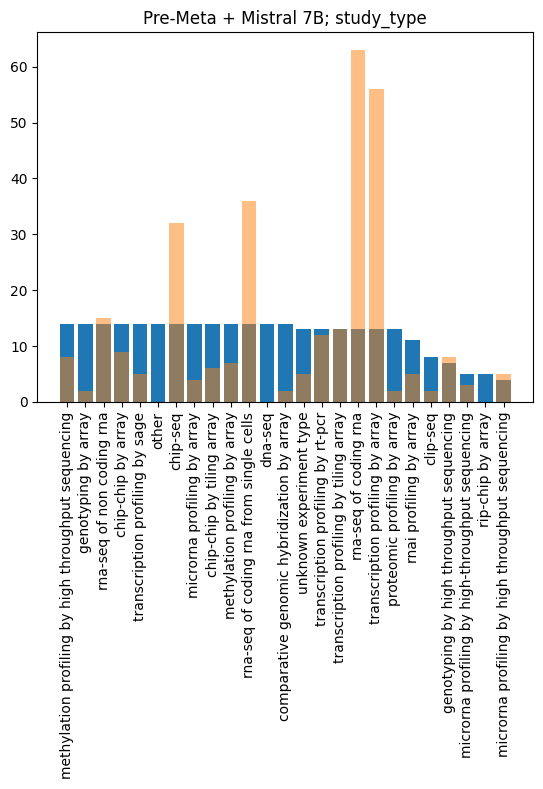

Vanilla RAG + Llama 8B


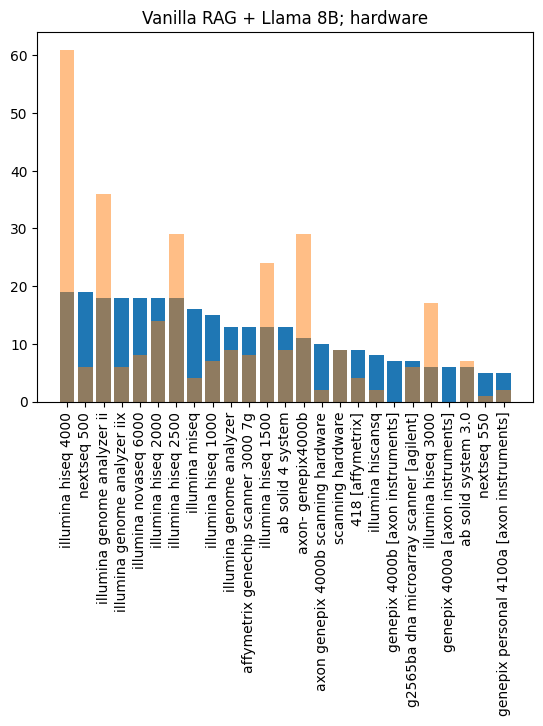

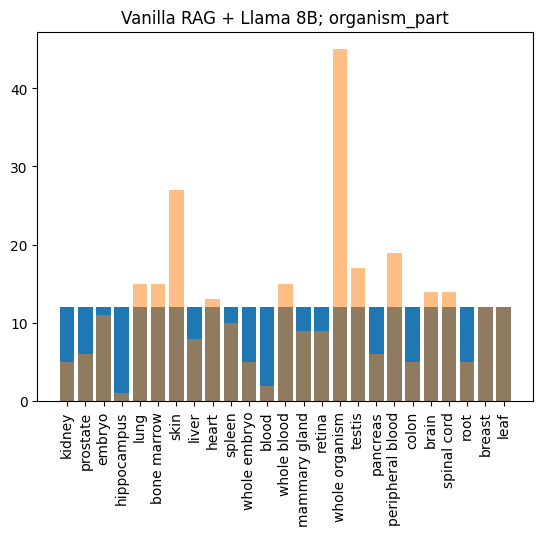

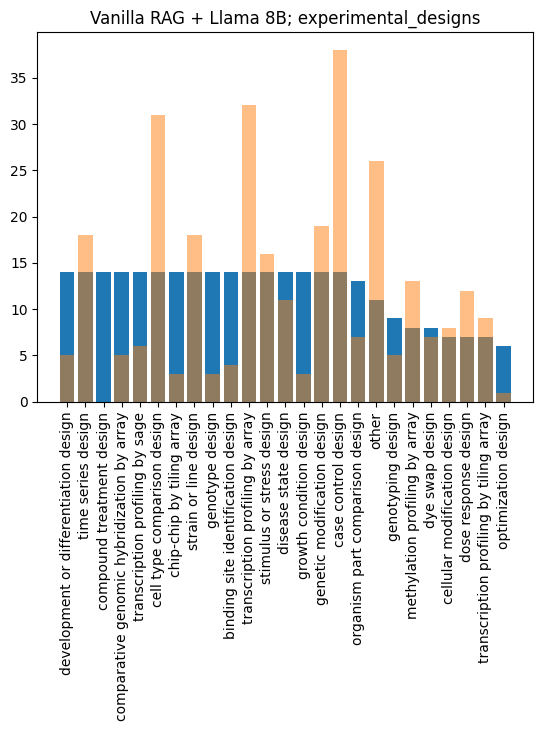

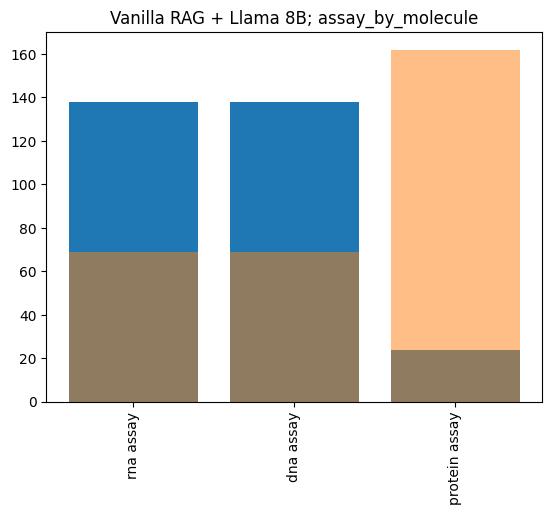

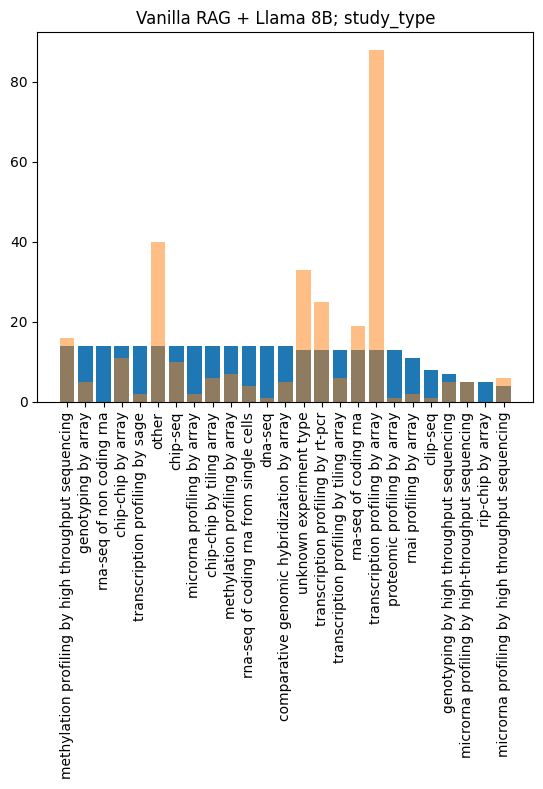

Vanilla RAG + Mistral 7B


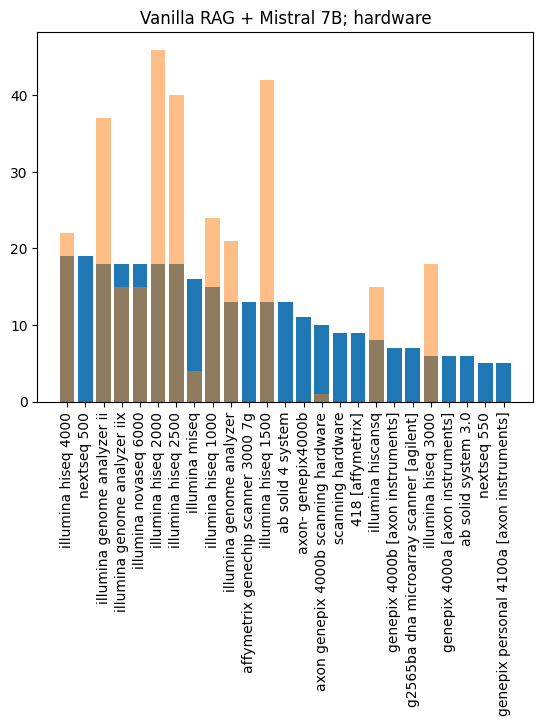

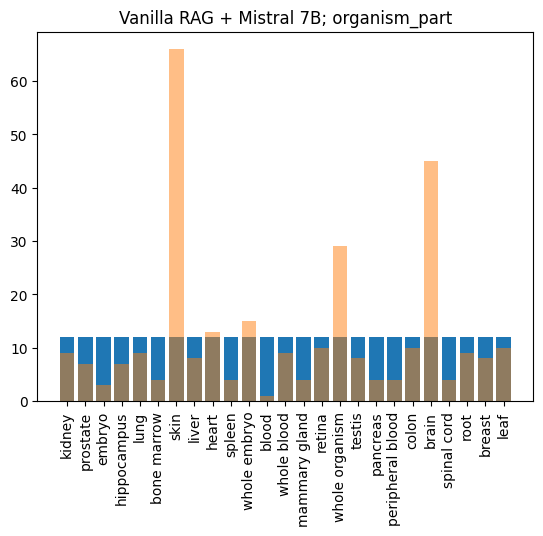

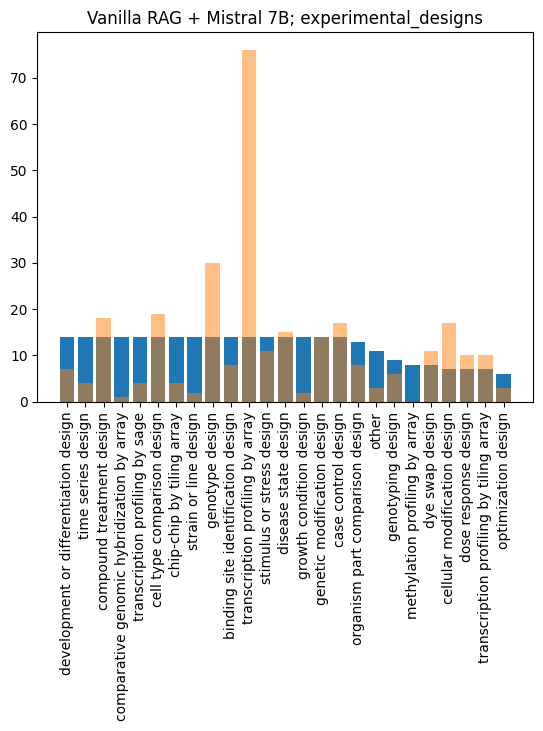

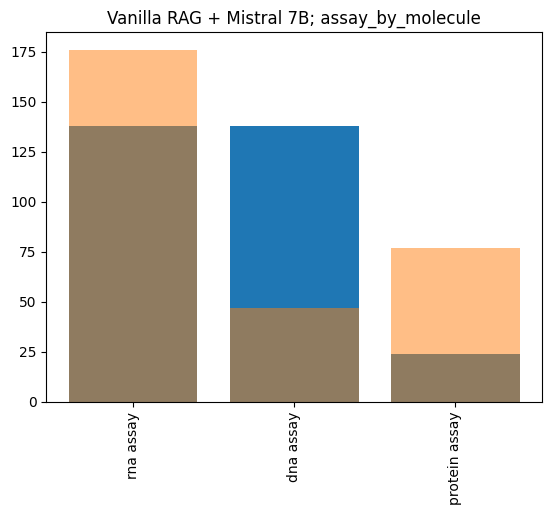

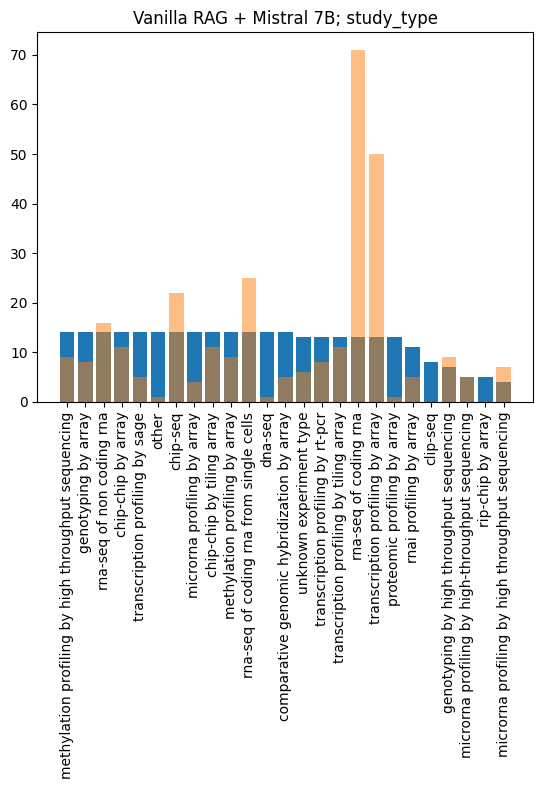

Pre-Meta Onto + Llama 8B


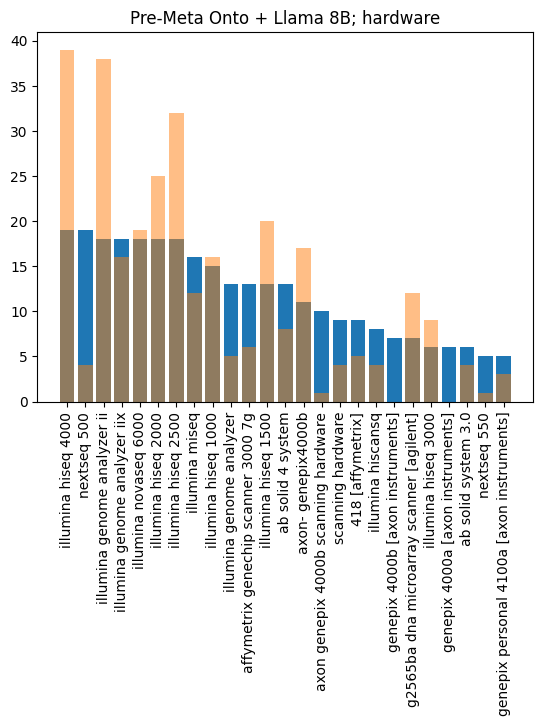

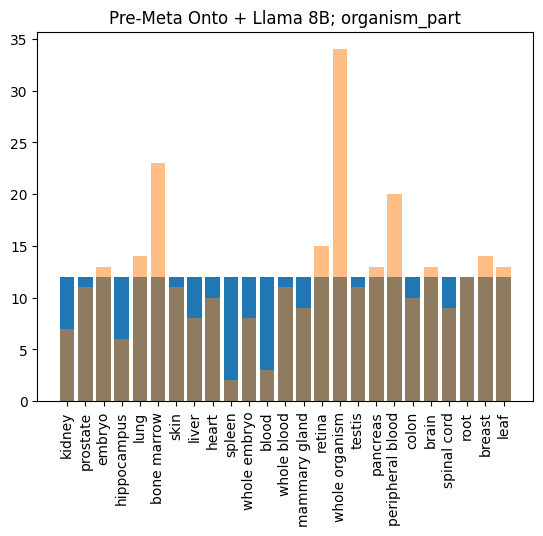

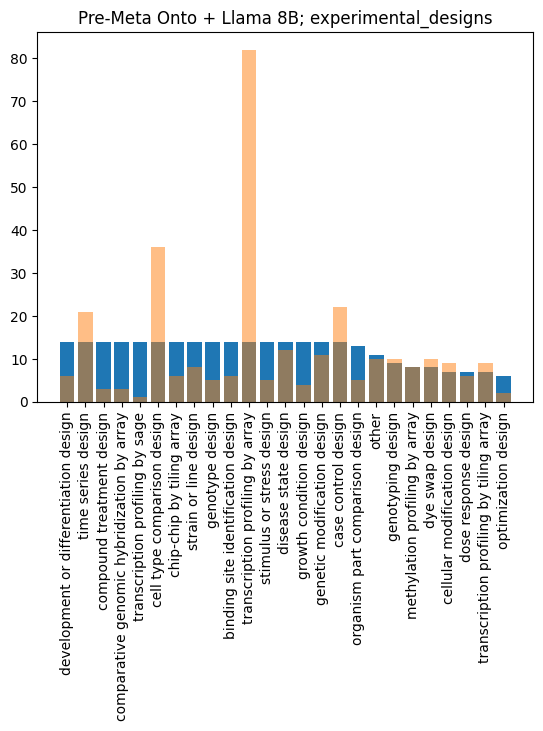

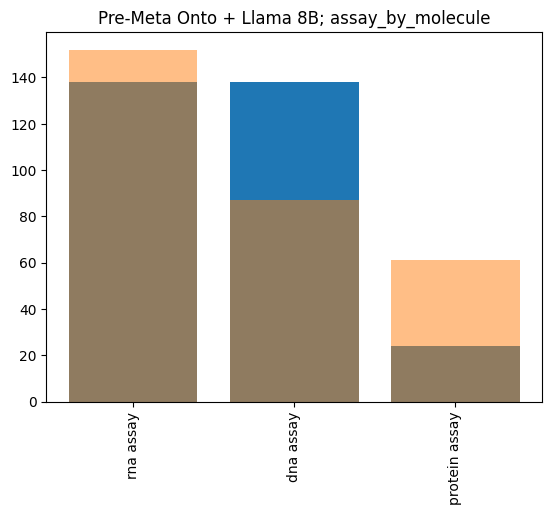

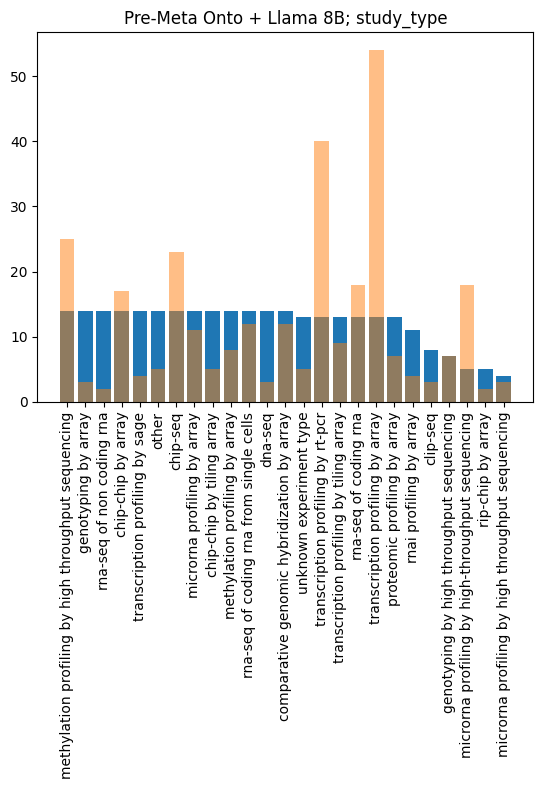

Pre-Meta Onto + Mistral 7B


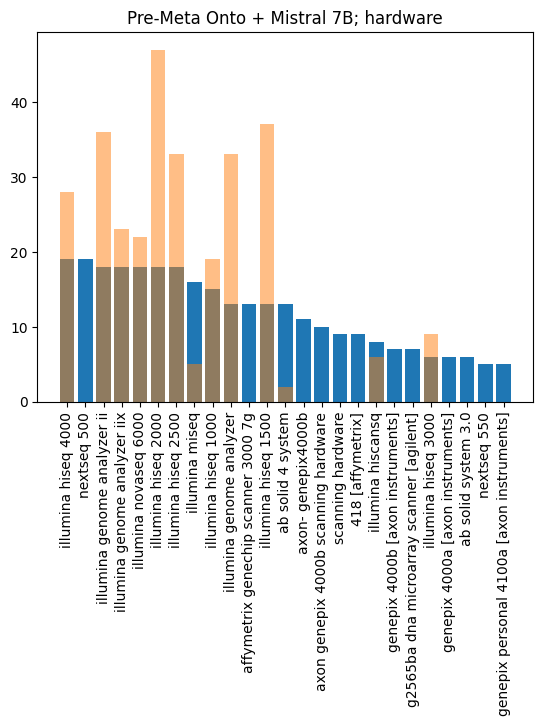

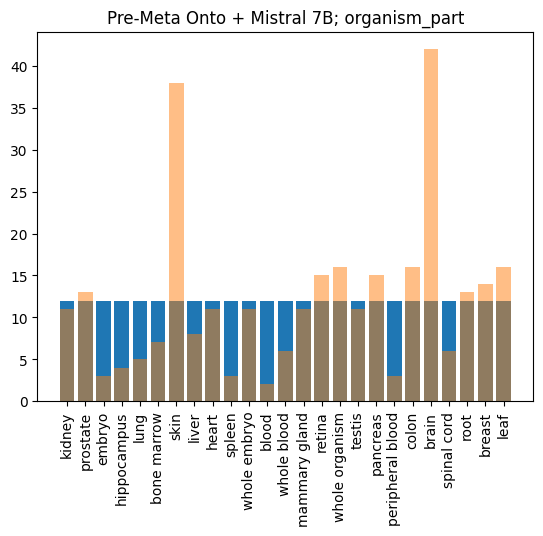

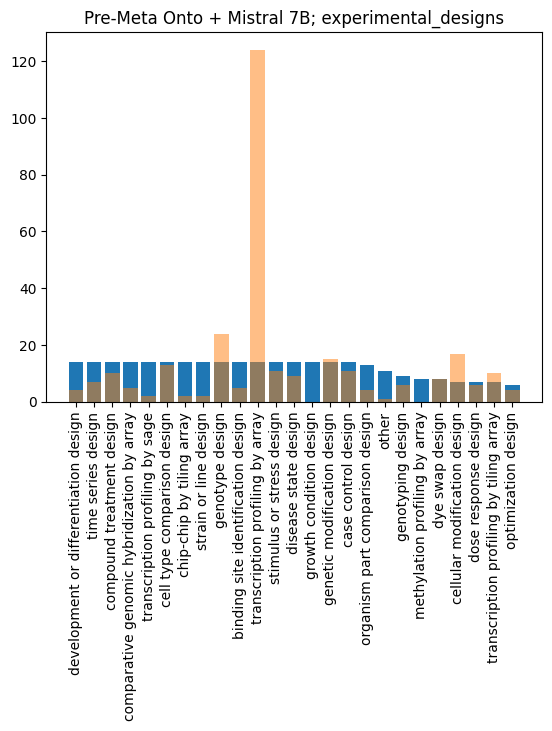

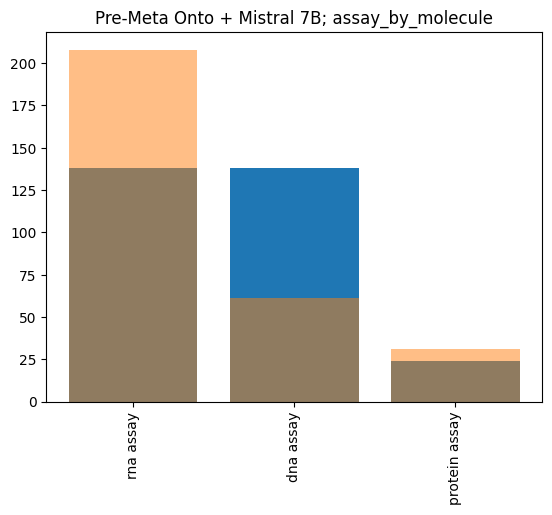

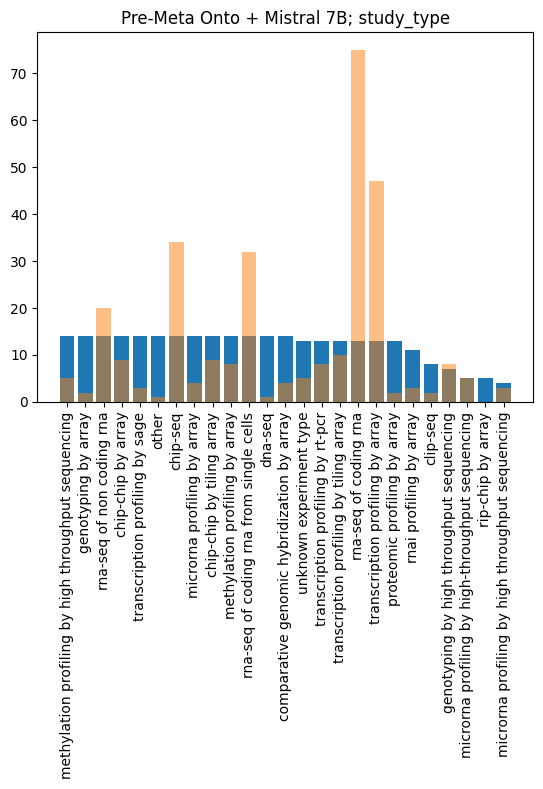

In [38]:

from collections import Counter
import metadata_schemas
schema = metadata_schemas.get_shuffled_arxpr2(25, v3=True)()



for argstring in choice_data:
    if ":" in shortnames_by_argstring[argstring]:
        continue

    print(shortnames_by_argstring[argstring])


    for field in choice_data[argstring]:
    
        labels= []
        preds = []

        #print(field)
        for label, pred in choice_data[argstring][field]:
            labels.append(label)
            preds.append(pred)
        
        commons = Counter(labels).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values())

        # include the rest of the labels (sorted by the default order, i.e. frequency i entire dataset)
        plt.bar(list(schema.__fields__[field].annotation.__args__), np.zeros(len(list(schema.__fields__[field].annotation.__args__))), color = "g")


        commons = Counter(preds).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values(), alpha=0.5)


        plt.xticks(rotation=90)
        plt.title(label=shortnames_by_argstring[argstring] + "; "+"_".join(field.split("_")[:-1]))

        
        plt.show()


### aggregated plots

now we aggregate all results for each model, and plot them

Mistral-7B hardware_4


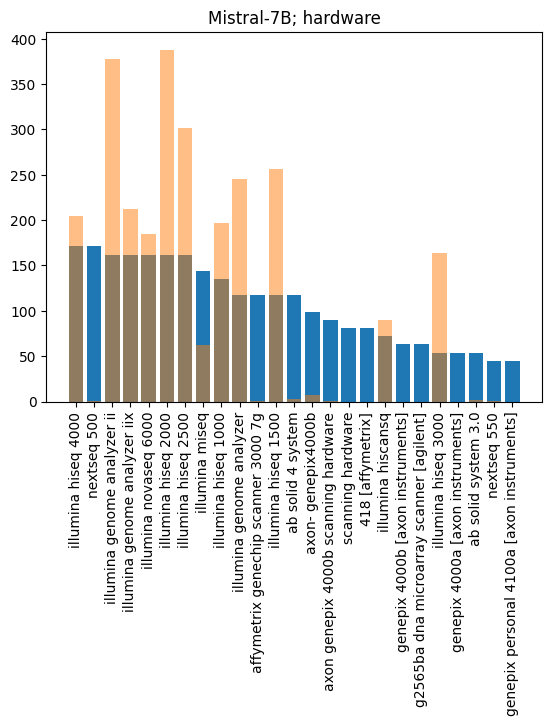

Mistral-7B organism_part_5


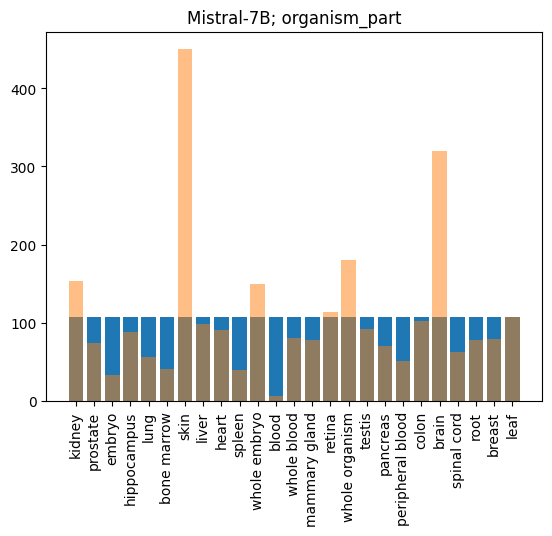

Mistral-7B experimental_designs_10


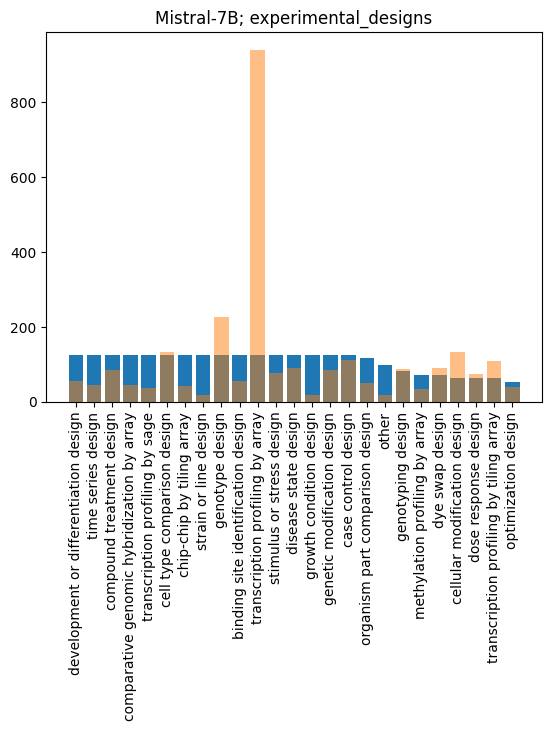

Mistral-7B assay_by_molecule_14


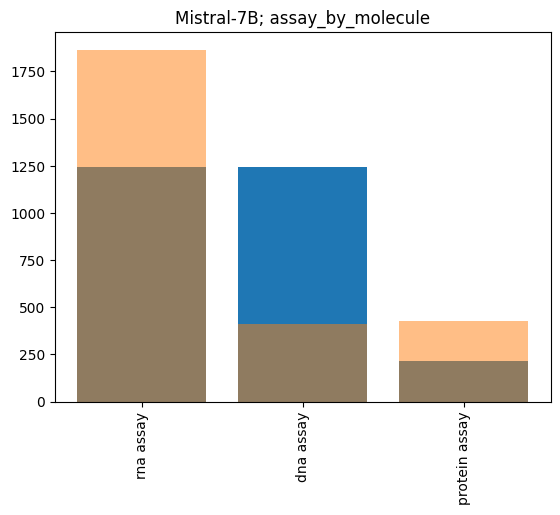

Mistral-7B study_type_18


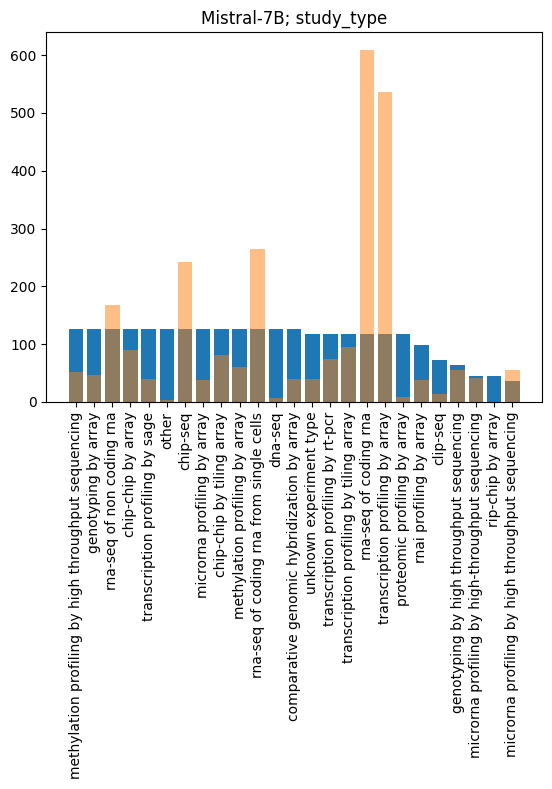

Meta-Llama-3.1 hardware_4


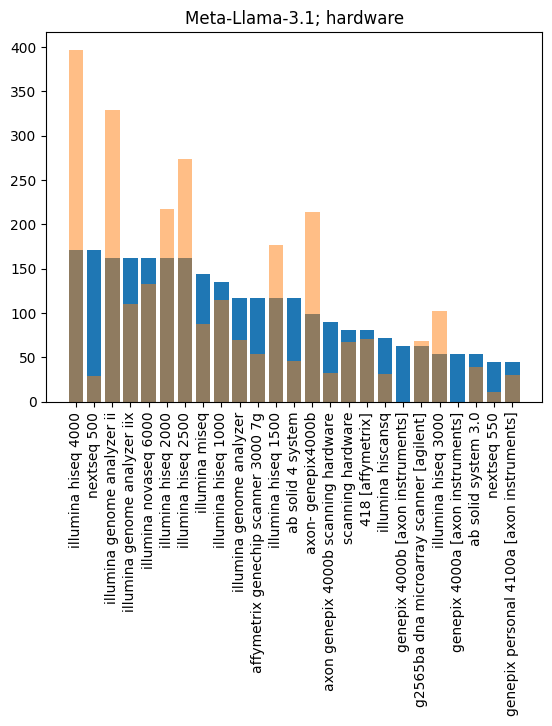

Meta-Llama-3.1 organism_part_5


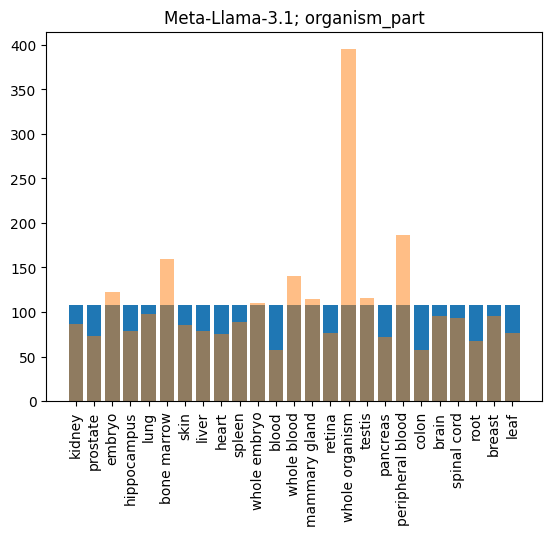

Meta-Llama-3.1 experimental_designs_10


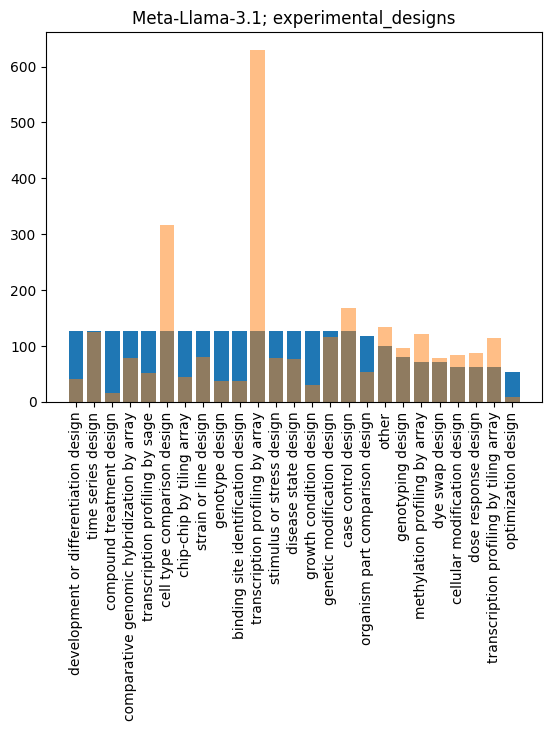

Meta-Llama-3.1 assay_by_molecule_14


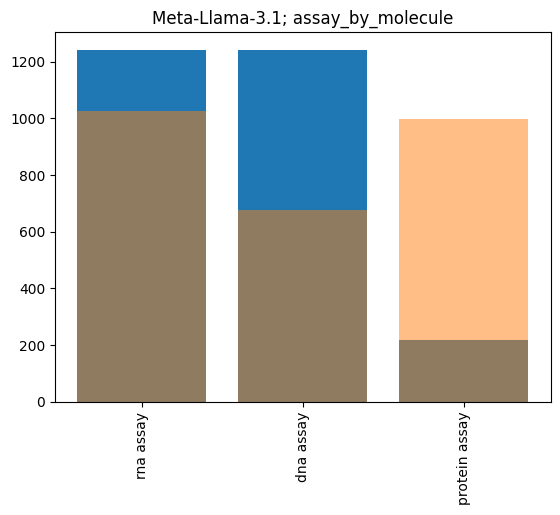

Meta-Llama-3.1 study_type_18


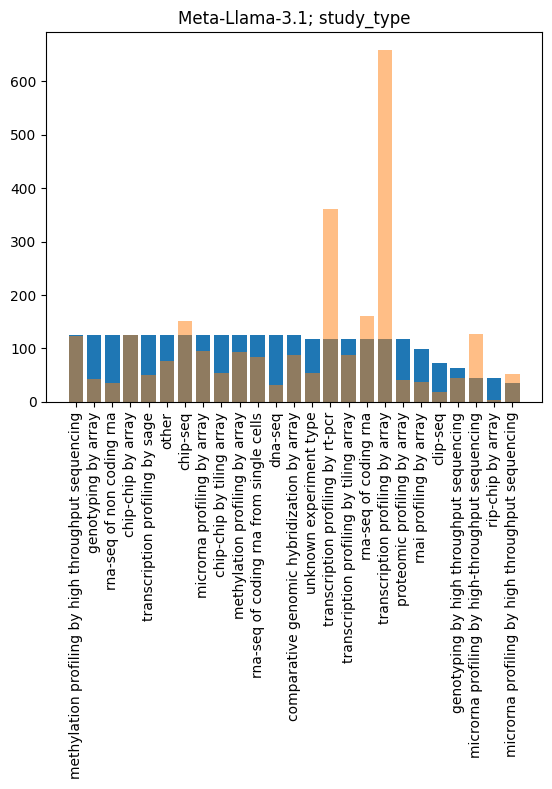

4om hardware_4


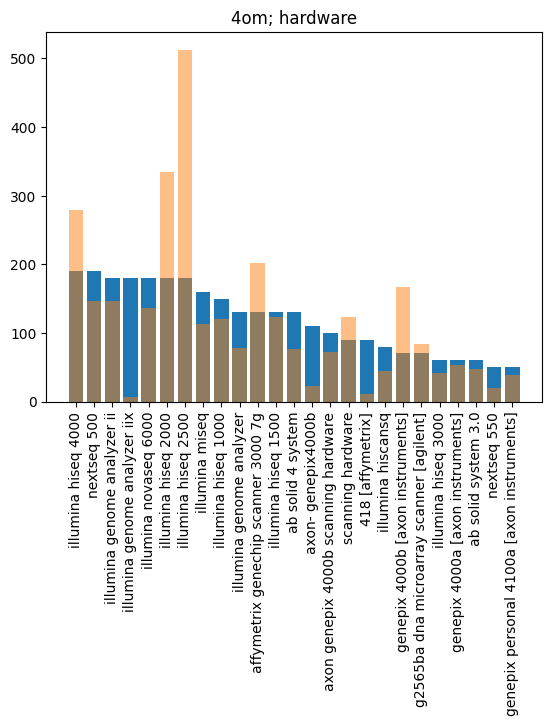

4om organism_part_5


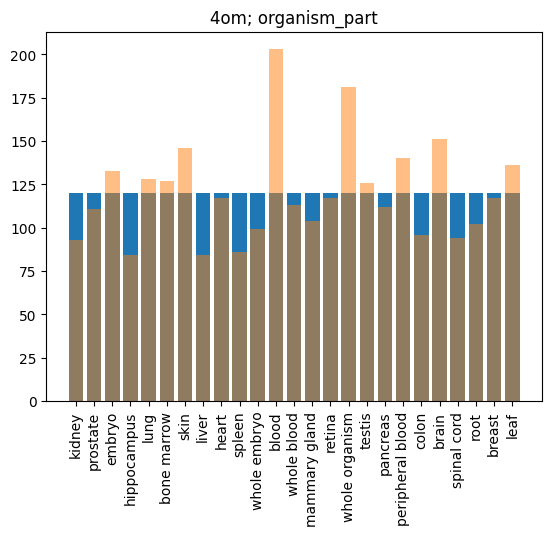

4om experimental_designs_10


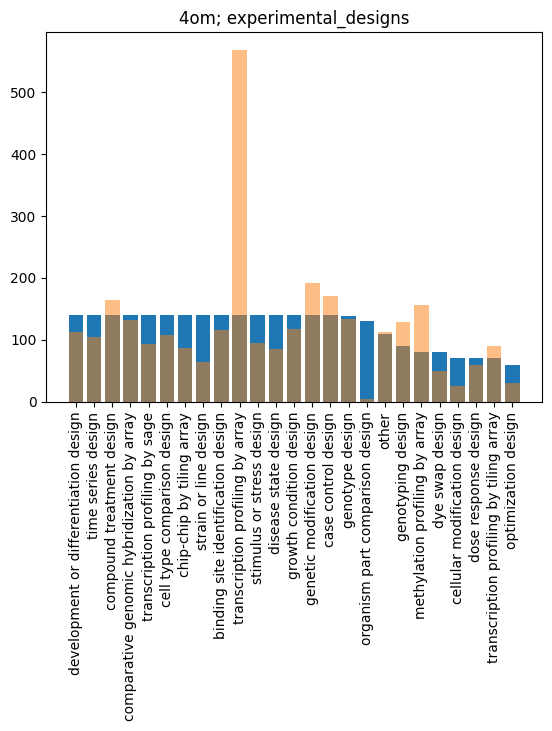

4om assay_by_molecule_14


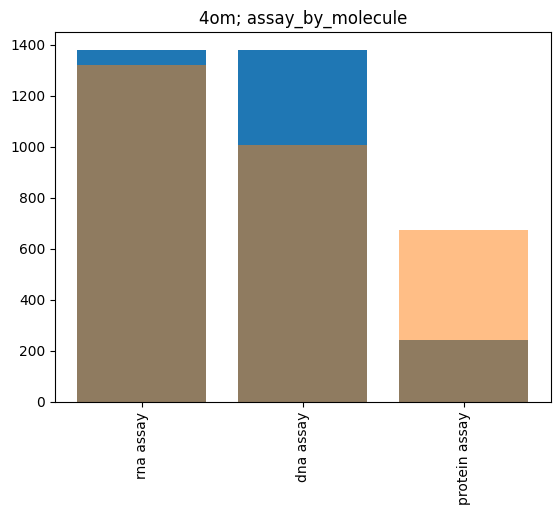

4om study_type_18


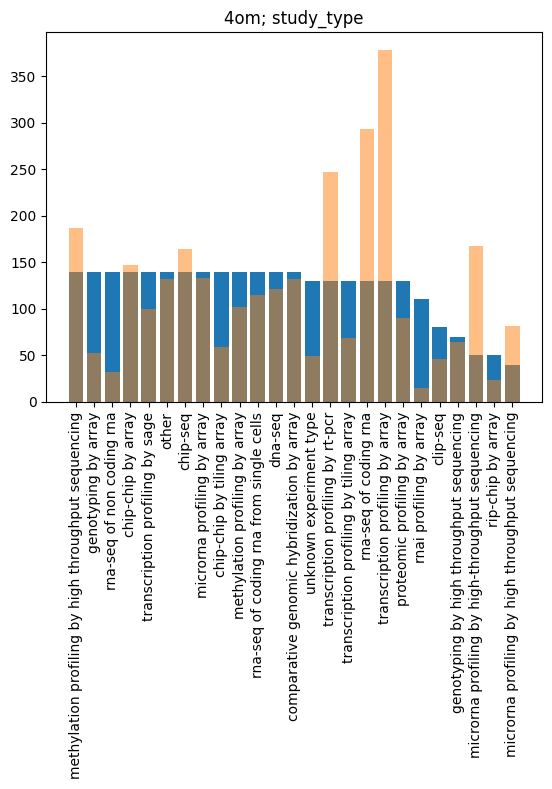

best_choice hardware_4


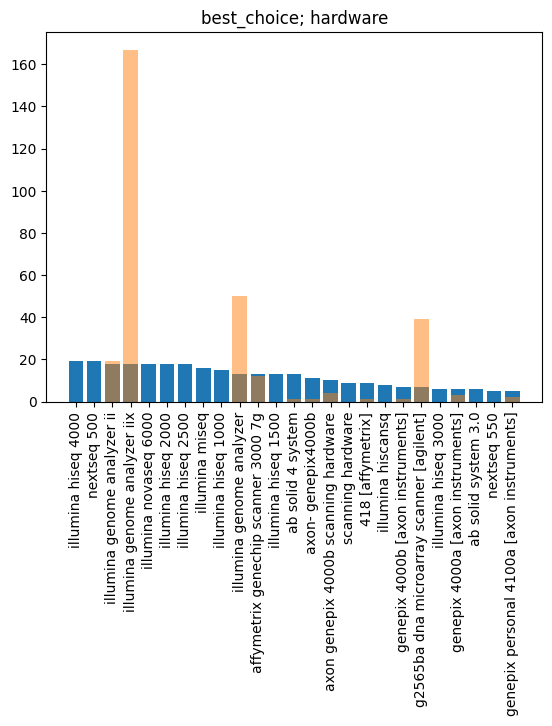

best_choice organism_part_5


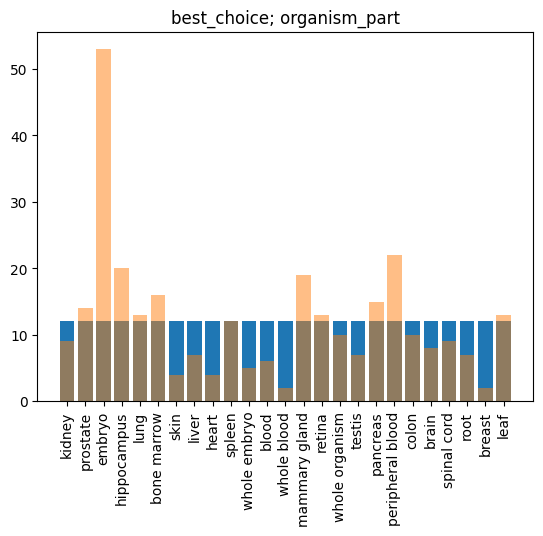

best_choice experimental_designs_10


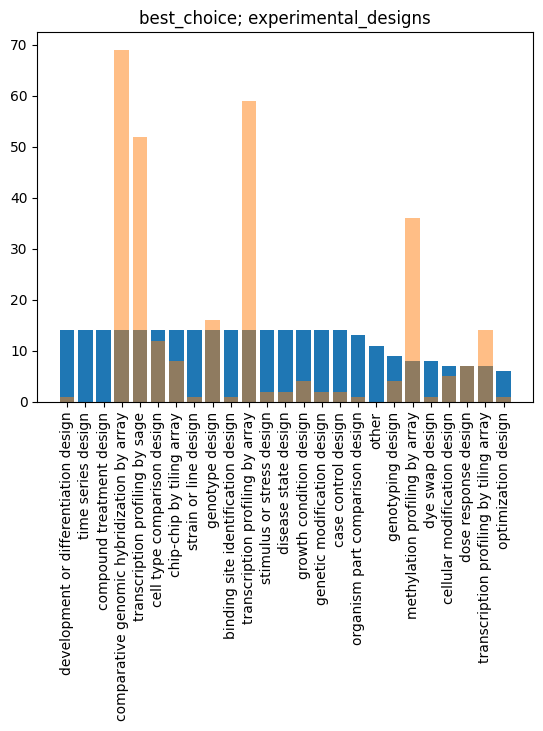

best_choice assay_by_molecule_14


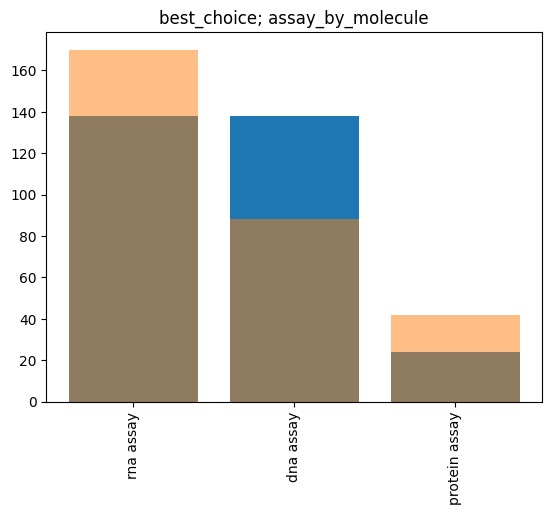

best_choice study_type_18


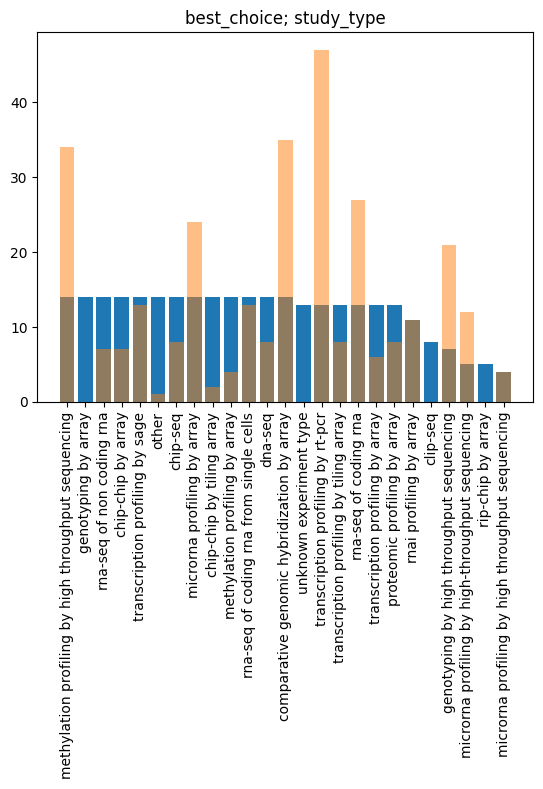

In [39]:


from collections import Counter
import metadata_schemas
schema = metadata_schemas.get_shuffled_arxpr2(25, v3=True)()

for argstring in choice_data:
    all_fields = []
    for field in choice_data[argstring]:
        all_fields.append(field)
    break




for term in ["Mistral-7B", "Meta-Llama-3.1", "4om", 
             #"DeepSeek", 
             "best_choice"]:

    #print(shortnames_by_argstring[argstring])
    for field in all_fields:
        print(term, field)
    
        labels= []
        preds = []

        #print(field)
        for argstring in choice_data:
            if term in argstring:
                for label, pred in choice_data[argstring][field]:
                    labels.append(label)
                    preds.append(pred)
            
        commons = Counter(labels).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values())

        # include the rest of the labels (sorted by the default order, i.e. frequency i entire dataset)
        plt.bar(list(schema.__fields__[field].annotation.__args__), np.zeros(len(list(schema.__fields__[field].annotation.__args__))), color = "g")


        commons = Counter(preds).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values(), alpha=0.5)


        plt.xticks(rotation=90)
        plt.title(label=term + "; "+"_".join(field.split("_")[:-1]))

        
        plt.show()




## wierd distribution investigations
(work in progress)

it seems, for mistral, it just is very likely to choose either correct or the first one. Maybe it, to a large extent compared to the other ones, picks the first one where the other would pick a "random" when it is not sure? Should look into this some more

In [40]:
for argstring in choice_data:
    if "Mistral" in argstring:# and "choice-list" in argstring:

        print(shortnames_by_argstring[argstring])


        for field in choice_data[argstring]:
        


            #print(field)
            correct_choice = []
            correct_ids = []
            pred0 = []
            for label, pred in choice_data[argstring][field]:
                correct_choice.append(int(label == pred))
            for label, pred in index_data[argstring][field]:
                correct_ids.append(int(label == pred))
                pred0.append(pred==0)
            #print(correct_ids == correct_choice)
            print(sum(correct_choice), 
                  sum(pred0), 
                  sum(np.multiply(correct_choice, pred0)) # fraction of correct 0 out of all 100
                  )
            #print("")
        
            #print(index_data[argstring][field])



Pre-Meta + Mistral 7B
57 110 4
168 70 10
47 116 4
188 148 82
42 114 5
Pre-Meta:2 + Mistral 7B
51 105 4
122 88 4
35 121 7
165 130 68
43 101 4
Pre-Meta:3 + Mistral 7B
49 121 7
109 90 9
26 124 8
171 134 72
46 118 6
Pre-Meta:5 + Mistral 7B
49 124 6
89 115 8
29 118 8
170 123 65
35 110 6
Pre-Meta:8 + Mistral 7B
40 128 10
74 129 9
28 132 11
171 134 72
37 134 12
Pre-Meta:12 + Mistral 7B
38 130 5
71 121 8
31 153 13
170 123 65
32 119 4
Pre-Meta:24 + Mistral 7B
40 137 8
48 151 9
16 161 6
172 133 72
45 141 23
Vanilla RAG + Mistral 7B
19 140 6
78 106 10
23 169 8
147 188 81
19 165 9
Pre-Meta Onto + Mistral 7B
50 118 12
124 102 10
28 144 11
193 146 81
37 127 9


# combined 4om distribution plot for paper

Pre-Meta + GPT-4o mini; hardware
Pre-Meta + GPT-4o mini; organism_part
Pre-Meta + GPT-4o mini; experimental_designs
Pre-Meta + GPT-4o mini; assay_by_molecule
Pre-Meta + GPT-4o mini; study_type


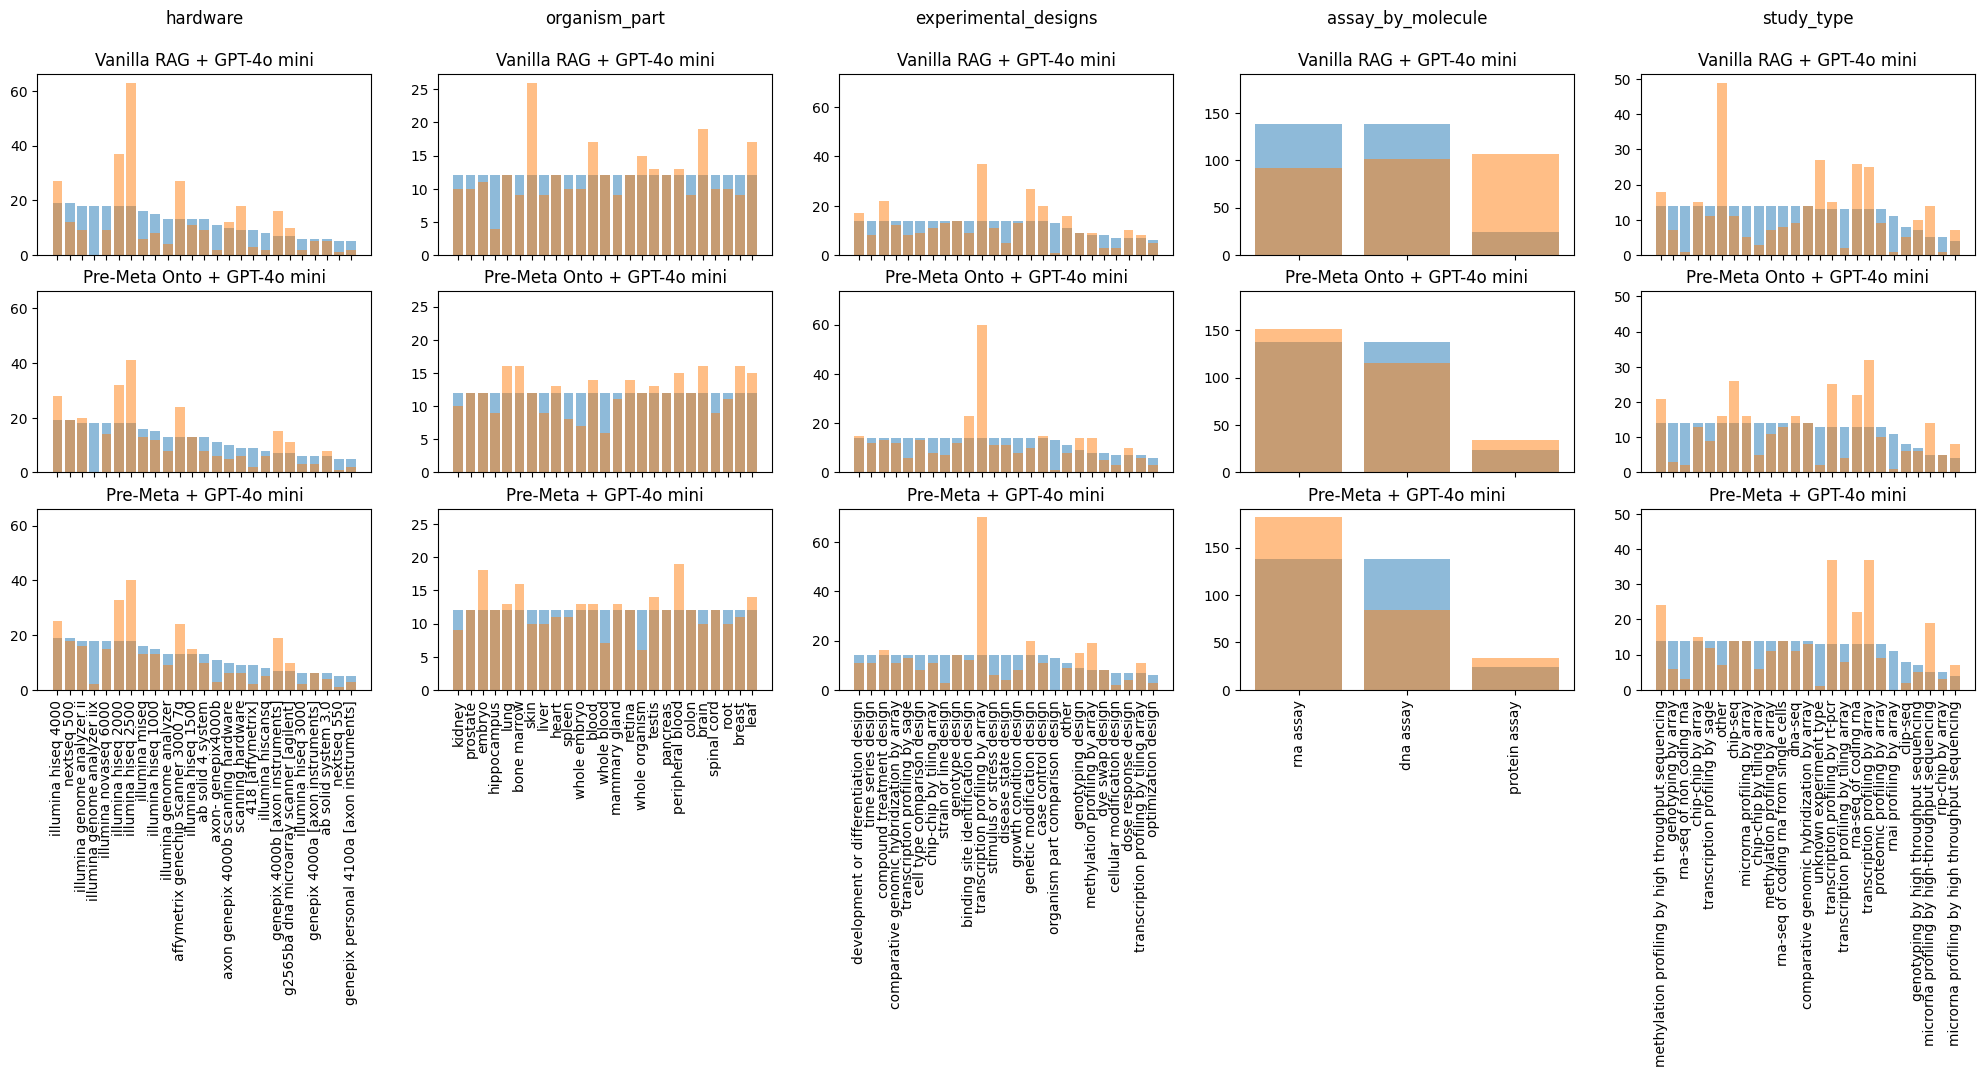

In [41]:
# in same plot

from collections import Counter
import metadata_schemas
schema = metadata_schemas.get_shuffled_arxpr2(25, v3=True)()

    


def plot_bars(argstring, field, color, ax, fieldtitle=False):

    labels = []
    preds = []

    #print(field)
    for label, pred in choice_data[argstring][field]:
        preds.append(pred)
        labels.append(label)
    
    # plot labels in backgronud
    commons = Counter(labels).most_common()
    commons = {t[0]:t[1] for t in commons}
    ax.bar(commons.keys(), commons.values(), alpha=0.5)

    # plot predictions
    commons = Counter(preds).most_common()
    commons = {t[0]:t[1] for t in commons}
    ax.bar(commons.keys(), commons.values(), color=color, alpha=0.5)#, yerr=np.array(list(commons.values()))*0, capsize=5, ecolor=ecolor)
    ax.set_title(
        label=(("_".join(field.split("_")[:-1]) +"\n\n") if fieldtitle else "")+  shortnames_by_argstring[argstring]
    )


def set_ticks(argstring, field, ax):
    #ax.set_xticks(rotation=90)
    ax.tick_params(axis='x', labelrotation=90)
    print(shortnames_by_argstring[argstring] + "; "+"_".join(field.split("_")[:-1]))

    

def argstring_by_shortname(shortname):
    for argstring in choice_data:
        if shortnames_by_argstring[argstring] == shortname:
            return argstring
    raise ValueError

fields = [
    "hardware_4",
    "organism_part_5",
    "experimental_designs_10",
    "assay_by_molecule_14",
    "study_type_18",
]


fig, axs = plt.subplots(3,5, sharex="col", sharey="col", figsize=(25,8))

for i, field in enumerate(fields):
    argstring = argstring_by_shortname("Pre-Meta + GPT-4o mini")
    #plot_label_bars(argstring, field, axs[0,i])
    plot_bars(argstring = argstring_by_shortname("Vanilla RAG + GPT-4o mini"), field= field, color=None, ax=axs[0,i], fieldtitle=True)
    plot_bars(argstring = argstring_by_shortname("Pre-Meta Onto + GPT-4o mini"), field=field, color=None, ax=axs[1,i])
    plot_bars(argstring = argstring_by_shortname("Pre-Meta + GPT-4o mini"), field=field, color=None, ax=axs[2,i])
    set_ticks(argstring, field, ax=axs[2,i])
    plt.plot()

